# Assignment 4: Graph analytics on Social Network Data

## Importing libraries & loading the dataset

In [1]:
import warnings
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#!pip install squarify
import squarify
import spacy
from tqdm import tqdm
import networkx as nx
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deboutte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change current directory
import os
os.chdir('/content/drive/MyDrive/KUL/AdvancedAnalytics/Assignment4')

In [2]:
# Loading the datasets
nva_tweets = pd.read_csv('NVA_tweets.csv',on_bad_lines='skip')
groen_tweets = pd.read_csv('Groen_tweets.csv',on_bad_lines='skip')

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/assignment4_NVA_tweets.csv'

In [ ]:
# Check nva tweets
nva_tweets.info()
nva_tweets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3475 entries, 0 to 3474
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          3475 non-null   int64  
 1   timeset     3475 non-null   object 
 2   LANGUAGE    3475 non-null   object 
 3   FAVORITE_C  3475 non-null   int64  
 4   QUOTE_C     3475 non-null   int64  
 5   REPLY_C     3475 non-null   int64  
 6   RETWEET_C   3475 non-null   int64  
 7   VIEWS_C     2795 non-null   float64
 8   full_text   3475 non-null   object 
dtypes: float64(1), int64(5), object(3)
memory usage: 244.5+ KB


,ID,timeset,LANGUAGE,FAVORITE_C,QUOTE_C,REPLY_C,RETWEET_C,VIEWS_C,full_text
0,1759271000850501861,2024-02-18T17:37:46+00:00,nl,93,3,19,30,8025.0,Schokkende beelden: “UNRWA-medewerker neemt li...
1,1759189343275466980,2024-02-18T12:13:18+00:00,nl,445,8,109,80,34771.0,"Vierdaagse werkweek van 32 uur, jongeren meer ..."
2,1758827733210071107,2024-02-17T12:16:23+00:00,qme,11,0,0,0,272.0,@de_NVA #voorVlaamsewelvaert https://t.co/74d2...
3,1758740358400274623,2024-02-17T06:29:11+00:00,nl,251,8,63,88,14767.0,UNWRA:Minstens 30 medewerkers zouden volgens I...
4,1758469657986564350,2024-02-16T12:33:31+00:00,nl,31,2,10,5,1541.0,1048 Jongeren tussen 18 en 24 jaar werden er i...


In [ ]:
# Check groen tweets
groen_tweets.info()
groen_tweets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1303 non-null   int64  
 1   timeset     1303 non-null   object 
 2   LANGUAGE    1303 non-null   object 
 3   FAVORITE_C  1303 non-null   int64  
 4   QUOTE_C     1303 non-null   int64  
 5   REPLY_C     1303 non-null   int64  
 6   RETWEET_C   1303 non-null   int64  
 7   VIEWS_C     764 non-null    float64
 8   full_text   1303 non-null   object 
dtypes: float64(1), int64(5), object(3)
memory usage: 91.7+ KB


,ID,timeset,LANGUAGE,FAVORITE_C,QUOTE_C,REPLY_C,RETWEET_C,VIEWS_C,full_text
0,1758849346303369265,2024-02-17T13:42:16+00:00,fr,45,5,20,9,5233.0,Avec @SamuelCogolati nous avons présenté notre...
1,1757398468925005926,2024-02-13T13:37:00+00:00,fr,43,2,19,4,2898.0,"Fierté, honneur: @ChaVanSnick rejoint les rang..."
2,1755248077462462694,2024-02-07T15:12:07+00:00,fr,24,0,2,3,1284.0,Heureuse de l’aboutissement de ce texte. Énorm...
3,1755298415838167495,2024-02-07T18:32:08+00:00,fr,0,0,1,0,23.0,"@CLTEVX @EmmanuelMacron @GabrielAttal Bonjour,..."
4,1755255471856902554,2024-02-07T15:41:30+00:00,fr,17,1,3,4,1237.0,"Chaque année, c’est l’équivalent d’une classe ..."


## Data cleaning & preprocessing

### Translating text to english

In [ ]:
#!pip install deep_translator
from deep_translator import GoogleTranslator

def translate_text(row):
    if row['LANGUAGE'] == 'nl':
      to_translate = row['full_text']
      translated = GoogleTranslator(source='nl', target='en').translate(to_translate)
      return translated
    elif row['LANGUAGE'] == 'fr':
      to_translate = row['full_text']
      translated = GoogleTranslator(source='fr', target='en').translate(to_translate)
      return translated
    elif row['LANGUAGE'] == 'en':
      return row['full_text']
    else:
      return None

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.3 MB/s eta 0:00:00


In [ ]:
# NVA
nva_tweets['LANGUAGE'].value_counts()
nva_tweets['translated_text'] = nva_tweets.apply(translate_text, axis=1)
nva_tweets = nva_tweets.dropna(subset=['translated_text'])

nva_tweets.head()

,ID,timeset,LANGUAGE,FAVORITE_C,QUOTE_C,REPLY_C,RETWEET_C,VIEWS_C,full_text,translated_text
0,1759271000850501861,2024-02-18T17:37:46+00:00,nl,93,3,19,30,8025.0,Schokkende beelden: “UNRWA-medewerker neemt li...,Shocking images: “UNRWA employee takes body of...
1,1759189343275466980,2024-02-18T12:13:18+00:00,nl,445,8,109,80,34771.0,"Vierdaagse werkweek van 32 uur, jongeren meer ...","Four-day working week of 32 hours, young peopl..."
3,1758740358400274623,2024-02-17T06:29:11+00:00,nl,251,8,63,88,14767.0,UNWRA:Minstens 30 medewerkers zouden volgens I...,UNWRA: At least 30 employees are said to be in...
4,1758469657986564350,2024-02-16T12:33:31+00:00,nl,31,2,10,5,1541.0,1048 Jongeren tussen 18 en 24 jaar werden er i...,"1,048 young people between the ages of 18 and ..."
5,1757657344710787269,2024-02-14T06:45:41+00:00,nl,0,0,0,163,NaN,RT @MichaelFreilich: Dringend strenger optrede...,RT @MichaelFreilich: Urgently stricter action ...


In [ ]:
# Groen
groen_tweets['LANGUAGE'].value_counts()
groen_tweets['translated_text'] = groen_tweets.apply(translate_text, axis=1)
groen_tweets = groen_tweets.dropna(subset=['translated_text'])

groen_tweets.head()

,ID,timeset,LANGUAGE,FAVORITE_C,QUOTE_C,REPLY_C,RETWEET_C,VIEWS_C,full_text,translated_text
0,1758849346303369265,2024-02-17T13:42:16+00:00,fr,45,5,20,9,5233.0,Avec @SamuelCogolati nous avons présenté notre...,With @SamuelCogolati we presented our team @ec...
1,1757398468925005926,2024-02-13T13:37:00+00:00,fr,43,2,19,4,2898.0,"Fierté, honneur: @ChaVanSnick rejoint les rang...","Pride, honor: @ChaVanSnick joins the ranks of ..."
2,1755248077462462694,2024-02-07T15:12:07+00:00,fr,24,0,2,3,1284.0,Heureuse de l’aboutissement de ce texte. Énorm...,Happy with the outcome of this text. Huge disa...
3,1755298415838167495,2024-02-07T18:32:08+00:00,fr,0,0,1,0,23.0,"@CLTEVX @EmmanuelMacron @GabrielAttal Bonjour,...","@CLTEVX @EmmanuelMacron @GabrielAttal Hello, B..."
4,1755255471856902554,2024-02-07T15:41:30+00:00,fr,17,1,3,4,1237.0,"Chaque année, c’est l’équivalent d’une classe ...","Each year, the equivalent of a class is decima..."


### Regular expressions

In [ ]:
# NVA
nva_tweets['translated_text'] = nva_tweets['translated_text'].astype(str) # Converting col to string
nva_tweets['translated_text'] = nva_tweets['translated_text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)) # Removing unwanted characters
nva_tweets['translated_text'] = nva_tweets['translated_text'].str.lower() # Lower case
print(nva_tweets['translated_text'])

0       shocking images unrwa employee takes body of m...
1       fourday working week of 32 hours young people ...
3       unwra at least 30 employees are said to be inv...
4       1048 young people between the ages of 18 and 2...
5       rt michaelfreilich urgently stricter action is...
                              ...                        
3470    a nice walk to scherpenheuvel flanders shines ...
3471    another late parliamentary session in dekamerb...
3472    paulganck trendskanaalz definitely you cannot ...
3473    british debt collection agency epcplc continue...
3474    stapnstap its about respecting gdpr and privac...
Name: translated_text, Length: 3320, dtype: object


In [ ]:
# Groen
groen_tweets['translated_text'] = groen_tweets['translated_text'].astype(str) # Converting col to string
groen_tweets['translated_text'] = groen_tweets['translated_text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)) # Removing unwanted characters
groen_tweets['translated_text'] = groen_tweets['translated_text'].str.lower() # Lower case
print(groen_tweets['translated_text'])

0       with samuelcogolati we presented our team ecol...
1       pride honor chavansnick joins the ranks of eco...
2       happy with the outcome of this text huge disap...
3       cltevx emmanuelmacron gabrielattal hello belgi...
4       each year the equivalent of a class is decimat...
                              ...                        
1298    rt ecolo burnout symptom of a working world th...
1299    rt ecolo burnout symptom of a working world th...
1300    rt ecolo burnout symptom of a working world th...
1301    rt rglucks1 your own activists contradict your...
1302    desideriojulien mrofficiel vincentvp the simpl...
Name: translated_text, Length: 1268, dtype: object


### Stopwords removal

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
# NVA
nva_tweets['translated_text'] = nva_tweets['translated_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])) # Remove stop words from text column
print(nva_tweets['translated_text'])

0       shocking images unrwa employee takes body murd...
1       fourday working week 32 hours young people tim...
3       unwra least 30 employees said involved terrori...
4       1048 young people ages 18 24 placed forced adm...
5       rt michaelfreilich urgently stricter action ne...
                              ...                        
3470    nice walk scherpenheuvel flanders shines sun b...
3471    another late parliamentary session dekamerbe w...
3472    paulganck trendskanaalz definitely cannot just...
3473    british debt collection agency epcplc continue...
3474    stapnstap respecting gdpr privacy rules obtain...
Name: translated_text, Length: 3320, dtype: object


In [ ]:
# Groen
groen_tweets['translated_text'] = groen_tweets['translated_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])) # Remove stop words from text column
print(groen_tweets['translated_text'])

0       samuelcogolati presented team ecolobe chamber ...
1       pride honor chavansnick joins ranks ecolo prov...
2       happy outcome text huge disappointment withdra...
3       cltevx emmanuelmacron gabrielattal hello belgi...
4       year equivalent class decimated circumstances ...
                              ...                        
1298    rt ecolo burnout symptom working world going h...
1299    rt ecolo burnout symptom working world going h...
1300    rt ecolo burnout symptom working world going h...
1301    rt rglucks1 activists contradict version proba...
1302    desideriojulien mrofficiel vincentvp simple fa...
Name: translated_text, Length: 1268, dtype: object


### Tokenization


In [ ]:
nltk.download('punkt')
import nltk
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# NVA
nva_tweets['translated_text'] = nva_tweets['translated_text'].apply(lambda x: word_tokenize(x)) # Tokenize text column
print(nva_tweets['translated_text'])

0       [shocking, images, unrwa, employee, takes, bod...
1       [fourday, working, week, 32, hours, young, peo...
3       [unwra, least, 30, employees, said, involved, ...
4       [1048, young, people, ages, 18, 24, placed, fo...
5       [rt, michaelfreilich, urgently, stricter, acti...
                              ...                        
3470    [nice, walk, scherpenheuvel, flanders, shines,...
3471    [another, late, parliamentary, session, dekame...
3472    [paulganck, trendskanaalz, definitely, can, no...
3473    [british, debt, collection, agency, epcplc, co...
3474    [stapnstap, respecting, gdpr, privacy, rules, ...
Name: translated_text, Length: 3320, dtype: object


In [ ]:
# Groen
groen_tweets['translated_text'] = groen_tweets['translated_text'].apply(lambda x: word_tokenize(x)) # Tokenize text column
print(groen_tweets['translated_text'])

0       [samuelcogolati, presented, team, ecolobe, cha...
1       [pride, honor, chavansnick, joins, ranks, ecol...
2       [happy, outcome, text, huge, disappointment, w...
3       [cltevx, emmanuelmacron, gabrielattal, hello, ...
4       [year, equivalent, class, decimated, circumsta...
                              ...                        
1298    [rt, ecolo, burnout, symptom, working, world, ...
1299    [rt, ecolo, burnout, symptom, working, world, ...
1300    [rt, ecolo, burnout, symptom, working, world, ...
1301    [rt, rglucks1, activists, contradict, version,...
1302    [desideriojulien, mrofficiel, vincentvp, simpl...
Name: translated_text, Length: 1268, dtype: object


### Stemming & Lemmentization


In [ ]:
nltk.download('wordnet')
stemmer = PorterStemmer() # Create stemmer
lemmatizer = WordNetLemmatizer() # Create lemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# NVA
nva_tweets['stemmed_text'] = nva_tweets['translated_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x])) # Stem each word in the tokenized text and join them back into a string
nva_tweets['lemmatized_text'] = nva_tweets['translated_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x])) # Lemmatize each word in the tokenized text and join them back into a string
nva_tweets.head()

,ID,timeset,LANGUAGE,FAVORITE_C,QUOTE_C,REPLY_C,RETWEET_C,VIEWS_C,full_text,translated_text,stemmed_text,lemmatized_text
0,1759271000850501861,2024-02-18T17:37:46+00:00,nl,93,3,19,30,8025.0,Schokkende beelden: “UNRWA-medewerker neemt li...,"[shocking, images, unrwa, employee, takes, bod...",shock imag unrwa employe take bodi murder isra...,shocking image unrwa employee take body murder...
1,1759189343275466980,2024-02-18T12:13:18+00:00,nl,445,8,109,80,34771.0,"Vierdaagse werkweek van 32 uur, jongeren meer ...","[fourday, working, week, 32, hours, young, peo...",fourday work week 32 hour young peopl time hom...,fourday working week 32 hour young people time...
3,1758740358400274623,2024-02-17T06:29:11+00:00,nl,251,8,63,88,14767.0,UNWRA:Minstens 30 medewerkers zouden volgens I...,"[unwra, least, 30, employees, said, involved, ...",unwra least 30 employe said involv terrorist a...,unwra least 30 employee said involved terroris...
4,1758469657986564350,2024-02-16T12:33:31+00:00,nl,31,2,10,5,1541.0,1048 Jongeren tussen 18 en 24 jaar werden er i...,"[1048, young, people, ages, 18, 24, placed, fo...",1048 young peopl age 18 24 place forc admiss 2...,1048 young people age 18 24 placed forced admi...
5,1757657344710787269,2024-02-14T06:45:41+00:00,nl,0,0,0,163,NaN,RT @MichaelFreilich: Dringend strenger optrede...,"[rt, michaelfreilich, urgently, stricter, acti...",rt michaelfreilich urgent stricter action need...,rt michaelfreilich urgently stricter action ne...


In [ ]:
nva_tweets['stemmed_text'] = nva_tweets['stemmed_text'].apply(lambda x: x.split())
nva_tweets['lemmatized_text'] = nva_tweets['lemmatized_text'].apply(lambda x: x.split())
nva_tweets.head()

,ID,timeset,LANGUAGE,FAVORITE_C,QUOTE_C,REPLY_C,RETWEET_C,VIEWS_C,full_text,translated_text,stemmed_text,lemmatized_text
0,1759271000850501861,2024-02-18T17:37:46+00:00,nl,93,3,19,30,8025.0,Schokkende beelden: “UNRWA-medewerker neemt li...,"[shocking, images, unrwa, employee, takes, bod...","[shock, imag, unrwa, employe, take, bodi, murd...","[shocking, image, unrwa, employee, take, body,..."
1,1759189343275466980,2024-02-18T12:13:18+00:00,nl,445,8,109,80,34771.0,"Vierdaagse werkweek van 32 uur, jongeren meer ...","[fourday, working, week, 32, hours, young, peo...","[fourday, work, week, 32, hour, young, peopl, ...","[fourday, working, week, 32, hour, young, peop..."
3,1758740358400274623,2024-02-17T06:29:11+00:00,nl,251,8,63,88,14767.0,UNWRA:Minstens 30 medewerkers zouden volgens I...,"[unwra, least, 30, employees, said, involved, ...","[unwra, least, 30, employe, said, involv, terr...","[unwra, least, 30, employee, said, involved, t..."
4,1758469657986564350,2024-02-16T12:33:31+00:00,nl,31,2,10,5,1541.0,1048 Jongeren tussen 18 en 24 jaar werden er i...,"[1048, young, people, ages, 18, 24, placed, fo...","[1048, young, peopl, age, 18, 24, place, forc,...","[1048, young, people, age, 18, 24, placed, for..."
5,1757657344710787269,2024-02-14T06:45:41+00:00,nl,0,0,0,163,NaN,RT @MichaelFreilich: Dringend strenger optrede...,"[rt, michaelfreilich, urgently, stricter, acti...","[rt, michaelfreilich, urgent, stricter, action...","[rt, michaelfreilich, urgently, stricter, acti..."


In [ ]:
# Groen
groen_tweets['stemmed_text'] = groen_tweets['translated_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x])) # Stem each word in the tokenized text and join them back into a string
groen_tweets['lemmatized_text'] = groen_tweets['translated_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x])) # Lemmatize each word in the tokenized text and join them back into a string
groen_tweets.head()

,ID,timeset,LANGUAGE,FAVORITE_C,QUOTE_C,REPLY_C,RETWEET_C,VIEWS_C,full_text,translated_text,stemmed_text,lemmatized_text
0,1758849346303369265,2024-02-17T13:42:16+00:00,fr,45,5,20,9,5233.0,Avec @SamuelCogolati nous avons présenté notre...,"[samuelcogolati, presented, team, ecolobe, cha...",samuelcogolati present team ecolob chamber lig...,samuelcogolati presented team ecolobe chamber ...
1,1757398468925005926,2024-02-13T13:37:00+00:00,fr,43,2,19,4,2898.0,"Fierté, honneur: @ChaVanSnick rejoint les rang...","[pride, honor, chavansnick, joins, ranks, ecol...",pride honor chavansnick join rank ecolo provin...,pride honor chavansnick join rank ecolo provin...
2,1755248077462462694,2024-02-07T15:12:07+00:00,fr,24,0,2,3,1284.0,Heureuse de l’aboutissement de ce texte. Énorm...,"[happy, outcome, text, huge, disappointment, w...",happi outcom text huge disappoint withdraw def...,happy outcome text huge disappointment withdra...
3,1755298415838167495,2024-02-07T18:32:08+00:00,fr,0,0,1,0,23.0,"@CLTEVX @EmmanuelMacron @GabrielAttal Bonjour,...","[cltevx, emmanuelmacron, gabrielattal, hello, ...",cltevx emmanuelmacron gabrielatt hello belgium...,cltevx emmanuelmacron gabrielattal hello belgi...
4,1755255471856902554,2024-02-07T15:41:30+00:00,fr,17,1,3,4,1237.0,"Chaque année, c’est l’équivalent d’une classe ...","[year, equivalent, class, decimated, circumsta...",year equival class decim circumst belgium moth...,year equivalent class decimated circumstance b...


In [ ]:
groen_tweets['stemmed_text'] = groen_tweets['stemmed_text'].apply(lambda x: x.split())
groen_tweets['lemmatized_text'] = groen_tweets['lemmatized_text'].apply(lambda x: x.split())
groen_tweets.head()

,ID,timeset,LANGUAGE,FAVORITE_C,QUOTE_C,REPLY_C,RETWEET_C,VIEWS_C,full_text,translated_text,stemmed_text,lemmatized_text
0,1758849346303369265,2024-02-17T13:42:16+00:00,fr,45,5,20,9,5233.0,Avec @SamuelCogolati nous avons présenté notre...,"[samuelcogolati, presented, team, ecolobe, cha...","[samuelcogolati, present, team, ecolob, chambe...","[samuelcogolati, presented, team, ecolobe, cha..."
1,1757398468925005926,2024-02-13T13:37:00+00:00,fr,43,2,19,4,2898.0,"Fierté, honneur: @ChaVanSnick rejoint les rang...","[pride, honor, chavansnick, joins, ranks, ecol...","[pride, honor, chavansnick, join, rank, ecolo,...","[pride, honor, chavansnick, join, rank, ecolo,..."
2,1755248077462462694,2024-02-07T15:12:07+00:00,fr,24,0,2,3,1284.0,Heureuse de l’aboutissement de ce texte. Énorm...,"[happy, outcome, text, huge, disappointment, w...","[happi, outcom, text, huge, disappoint, withdr...","[happy, outcome, text, huge, disappointment, w..."
3,1755298415838167495,2024-02-07T18:32:08+00:00,fr,0,0,1,0,23.0,"@CLTEVX @EmmanuelMacron @GabrielAttal Bonjour,...","[cltevx, emmanuelmacron, gabrielattal, hello, ...","[cltevx, emmanuelmacron, gabrielatt, hello, be...","[cltevx, emmanuelmacron, gabrielattal, hello, ..."
4,1755255471856902554,2024-02-07T15:41:30+00:00,fr,17,1,3,4,1237.0,"Chaque année, c’est l’équivalent d’une classe ...","[year, equivalent, class, decimated, circumsta...","[year, equival, class, decim, circumst, belgiu...","[year, equivalent, class, decimated, circumsta..."


### Saving preprocessed data

In [ ]:
nva_tweets.to_csv('nva_tweets_preprocessed.csv', index=False)

In [ ]:
groen_tweets.to_csv('groen_tweets_preprocessed.csv', index=False)

## Topic modelling LDA & NMF


### Fitting different models
1. Create a document-term matrix
2. Fit the LDA model
3. Get word-topic distributions and document-topic distributions
4. Identify most representative documents for each topic
5. Compute coherence scores
6. Choose the best model and use it for clustering

### NVA

In [ ]:
# LDA on translated text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(nva_tweets["translated_text"].apply(lambda x: " ".join(x)))

# Fit LDA model v1
lda_model = LatentDirichletAllocation(n_components=15, random_state=42)
lda_model.fit(dtm)

# Get the topic-word distributions for LDA
lda_topic_word_distributions = lda_model.components_

# Get the document-topic distributions for LDA
lda_document_topic_distributions = lda_model.transform(dtm)

# Transform the document-term matrix using the fitted LDA model
lda_topic_documents = lda_model.transform(dtm).argmax(axis=1)

# For LDA
most_representative_documents_lda = []
for topic_id in range(lda_model.n_components):
    documents = nva_tweets.iloc[lda_topic_documents == topic_id].index
    most_representative_documents_lda.append(documents)

# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(nva_tweets['translated_text'])

# Replace most_representative_documents_lda with the appropriate variable
documents_per_topic_lda = most_representative_documents_lda

# Tokenize the documents for each topic
tokenized_documents = [tokenize(document) for document in documents_per_topic_lda]

# Calculate the coherence score using the c_v coherence measure
coherence_model_lda = CoherenceModel(
    topics=tokenized_documents,
    texts=nva_tweets['translated_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda = coherence_model_lda.get_coherence()

# Print the coherence score
print("LDA Topic Coherence Score: {:.4f}".format(coherence_lda))

LDA Topic Coherence Score: 0.3503


In [ ]:
# LDA on stemmed text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(nva_tweets["stemmed_text"].apply(lambda x: " ".join(x)))

# Fit LDA model v1
lda_model = LatentDirichletAllocation(n_components=15, random_state=42)
lda_model.fit(dtm)

# Get the topic-word distributions for LDA
lda_topic_word_distributions = lda_model.components_

# Get the document-topic distributions for LDA
lda_document_topic_distributions = lda_model.transform(dtm)

# Transform the document-term matrix using the fitted LDA model
lda_topic_documents = lda_model.transform(dtm).argmax(axis=1)

# For LDA
most_representative_documents_lda = []
for topic_id in range(lda_model.n_components):
    documents = nva_tweets.iloc[lda_topic_documents == topic_id].index
    most_representative_documents_lda.append(documents)

# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(nva_tweets['stemmed_text'])

# Replace most_representative_documents_lda with the appropriate variable
documents_per_topic_lda = most_representative_documents_lda

# Tokenize the documents for each topic
tokenized_documents = [tokenize(document) for document in documents_per_topic_lda]

# Calculate the coherence score using the c_v coherence measure
coherence_model_lda = CoherenceModel(
    topics=tokenized_documents,
    texts=nva_tweets['stemmed_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda = coherence_model_lda.get_coherence()

# Print the coherence score
print("LDA Topic Coherence Score: {:.4f}".format(coherence_lda))

LDA Topic Coherence Score: 0.2894


In [ ]:
# LDA on lemmatized_text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(nva_tweets["lemmatized_text"].apply(lambda x: " ".join(x)))

# Fit LDA model v1
lda_model = LatentDirichletAllocation(n_components=15, random_state=42)
lda_model.fit(dtm)

# Get the topic-word distributions for LDA
lda_topic_word_distributions = lda_model.components_

# Get the document-topic distributions for LDA
lda_document_topic_distributions = lda_model.transform(dtm)

# Transform the document-term matrix using the fitted LDA model
lda_topic_documents = lda_model.transform(dtm).argmax(axis=1)

# For LDA
most_representative_documents_lda = []
for topic_id in range(lda_model.n_components):
    documents = nva_tweets.iloc[lda_topic_documents == topic_id].index
    most_representative_documents_lda.append(documents)

# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(nva_tweets['lemmatized_text'])

# Replace most_representative_documents_lda with the appropriate variable
documents_per_topic_lda = most_representative_documents_lda

# Tokenize the documents for each topic
tokenized_documents = [tokenize(document) for document in documents_per_topic_lda]

# Calculate the coherence score using the c_v coherence measure
coherence_model_lda = CoherenceModel(
    topics=tokenized_documents,
    texts=nva_tweets['lemmatized_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda = coherence_model_lda.get_coherence()

# Print the coherence score
print("LDA Topic Coherence Score: {:.4f}".format(coherence_lda))

LDA Topic Coherence Score: 0.3530


In [ ]:
# NMF on translated text

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(nva_tweets["translated_text"].apply(lambda x: " ".join(x)))

# Fit NMF model
nmf_model = NMF(n_components=15, init="nndsvd", random_state=42)
nmf_model.fit(dtm)

# Get the topic-word distributions for NMF
nmf_topic_word_distributions = nmf_model.components_

# Get the document-topic distributions for NMF
nmf_document_topic_distributions = nmf_model.transform(dtm)

# Transform the document-term matrix using the fitted NMF model
nmf_topic_documents = nmf_model.transform(dtm).argmax(axis=1)

# For NMF
most_representative_documents_nmf = []
for topic_id in range(nmf_model.n_components):
    documents = nva_tweets.iloc[nmf_topic_documents == topic_id].index
    most_representative_documents_nmf.append(documents)

# Coherence scores
# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(nva_tweets['translated_text'])

# Replace most_representative_documents_nmf with the appropriate variable
documents_per_topic_nmf = most_representative_documents_nmf

# Tokenize the documents for each topic
tokenized_documents = [document for document in documents_per_topic_nmf]

# Calculate the coherence score using the c_v coherence measure
coherence_model_nmf = CoherenceModel(
    topics=tokenized_documents,
    texts=nva_tweets['translated_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_nmf = coherence_model_nmf.get_coherence()

# Print the coherence score
print("NMF Topic Coherence Score: {:.4f}".format(coherence_nmf))

NMF Topic Coherence Score: 0.5946


In [ ]:
# NMF on stemmed text

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(nva_tweets["stemmed_text"].apply(lambda x: " ".join(x)))

# Fit NMF model
nmf_model = NMF(n_components=15, init="nndsvd", random_state=42)
nmf_model.fit(dtm)

# Get the topic-word distributions for NMF
nmf_topic_word_distributions = nmf_model.components_

# Get the document-topic distributions for NMF
nmf_document_topic_distributions = nmf_model.transform(dtm)

# Transform the document-term matrix using the fitted NMF model
nmf_topic_documents = nmf_model.transform(dtm).argmax(axis=1)

# For NMF
most_representative_documents_nmf = []
for topic_id in range(nmf_model.n_components):
    documents = nva_tweets.iloc[nmf_topic_documents == topic_id].index
    most_representative_documents_nmf.append(documents)

# Coherence scores
# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(nva_tweets['stemmed_text'])

# Replace most_representative_documents_nmf with the appropriate variable
documents_per_topic_nmf = most_representative_documents_nmf

# Tokenize the documents for each topic
tokenized_documents = [document for document in documents_per_topic_nmf]

# Calculate the coherence score using the c_v coherence measure
coherence_model_nmf = CoherenceModel(
    topics=tokenized_documents,
    texts=nva_tweets['stemmed_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_nmf = coherence_model_nmf.get_coherence()

# Print the coherence score
print("NMF Topic Coherence Score: {:.4f}".format(coherence_nmf))

NMF Topic Coherence Score: 0.5888


In [ ]:
# NMF on lemmatized_text

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(nva_tweets["lemmatized_text"].apply(lambda x: " ".join(x)))

# Fit NMF model
nmf_model = NMF(n_components=15, init="nndsvd", random_state=42)
nmf_model.fit(dtm)

# Get the topic-word distributions for NMF
nmf_topic_word_distributions = nmf_model.components_

# Get the document-topic distributions for NMF
nmf_document_topic_distributions = nmf_model.transform(dtm)

# Transform the document-term matrix using the fitted NMF model
nmf_topic_documents = nmf_model.transform(dtm).argmax(axis=1)

# For NMF
most_representative_documents_nmf = []
for topic_id in range(nmf_model.n_components):
    documents = nva_tweets.iloc[nmf_topic_documents == topic_id].index
    most_representative_documents_nmf.append(documents)

# Coherence scores
# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(nva_tweets['lemmatized_text'])

# Replace most_representative_documents_nmf with the appropriate variable
documents_per_topic_nmf = most_representative_documents_nmf

# Tokenize the documents for each topic
tokenized_documents = [document for document in documents_per_topic_nmf]

# Calculate the coherence score using the c_v coherence measure
coherence_model_nmf = CoherenceModel(
    topics=tokenized_documents,
    texts=nva_tweets['lemmatized_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_nmf = coherence_model_nmf.get_coherence()

# Print the coherence score
print("NMF Topic Coherence Score: {:.4f}".format(coherence_nmf))

NMF Topic Coherence Score: 0.6085


NMF on Lemmatized text gives the best coherence score for NVA

### Groen

In [ ]:
# LDA on translated text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(groen_tweets["translated_text"].apply(lambda x: " ".join(x)))

# Fit LDA model v1
lda_model = LatentDirichletAllocation(n_components=15, random_state=42)
lda_model.fit(dtm)

# Get the topic-word distributions for LDA
lda_topic_word_distributions = lda_model.components_

# Get the document-topic distributions for LDA
lda_document_topic_distributions = lda_model.transform(dtm)

# Transform the document-term matrix using the fitted LDA model
lda_topic_documents = lda_model.transform(dtm).argmax(axis=1)

# For LDA
most_representative_documents_lda = []
for topic_id in range(lda_model.n_components):
    documents = groen_tweets.iloc[lda_topic_documents == topic_id].index
    most_representative_documents_lda.append(documents)

# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(groen_tweets['translated_text'])

# Replace most_representative_documents_lda with the appropriate variable
documents_per_topic_lda = most_representative_documents_lda

# Tokenize the documents for each topic
tokenized_documents = [tokenize(document) for document in documents_per_topic_lda]

# Calculate the coherence score using the c_v coherence measure
coherence_model_lda = CoherenceModel(
    topics=tokenized_documents,
    texts=groen_tweets['translated_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda = coherence_model_lda.get_coherence()

# Print the coherence score
print("LDA Topic Coherence Score: {:.4f}".format(coherence_lda))

LDA Topic Coherence Score: 0.3608


In [ ]:
# LDA on stemmed text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(groen_tweets["stemmed_text"].apply(lambda x: " ".join(x)))

# Fit LDA model v1
lda_model = LatentDirichletAllocation(n_components=15, random_state=42)
lda_model.fit(dtm)

# Get the topic-word distributions for LDA
lda_topic_word_distributions = lda_model.components_

# Get the document-topic distributions for LDA
lda_document_topic_distributions = lda_model.transform(dtm)

# Transform the document-term matrix using the fitted LDA model
lda_topic_documents = lda_model.transform(dtm).argmax(axis=1)

# For LDA
most_representative_documents_lda = []
for topic_id in range(lda_model.n_components):
    documents = groen_tweets.iloc[lda_topic_documents == topic_id].index
    most_representative_documents_lda.append(documents)

# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(groen_tweets['stemmed_text'])

# Replace most_representative_documents_lda with the appropriate variable
documents_per_topic_lda = most_representative_documents_lda

# Tokenize the documents for each topic
tokenized_documents = [tokenize(document) for document in documents_per_topic_lda]

# Calculate the coherence score using the c_v coherence measure
coherence_model_lda = CoherenceModel(
    topics=tokenized_documents,
    texts=groen_tweets['stemmed_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda = coherence_model_lda.get_coherence()

# Print the coherence score
print("LDA Topic Coherence Score: {:.4f}".format(coherence_lda))

LDA Topic Coherence Score: 0.3360


In [ ]:
# LDA on lemmatized_text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(groen_tweets["lemmatized_text"].apply(lambda x: " ".join(x)))

# Fit LDA model v1
lda_model = LatentDirichletAllocation(n_components=15, random_state=42)
lda_model.fit(dtm)

# Get the topic-word distributions for LDA
lda_topic_word_distributions = lda_model.components_

# Get the document-topic distributions for LDA
lda_document_topic_distributions = lda_model.transform(dtm)

# Transform the document-term matrix using the fitted LDA model
lda_topic_documents = lda_model.transform(dtm).argmax(axis=1)

# For LDA
most_representative_documents_lda = []
for topic_id in range(lda_model.n_components):
    documents = groen_tweets.iloc[lda_topic_documents == topic_id].index
    most_representative_documents_lda.append(documents)

# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(groen_tweets['lemmatized_text'])

# Replace most_representative_documents_lda with the appropriate variable
documents_per_topic_lda = most_representative_documents_lda

# Tokenize the documents for each topic
tokenized_documents = [tokenize(document) for document in documents_per_topic_lda]

# Calculate the coherence score using the c_v coherence measure
coherence_model_lda = CoherenceModel(
    topics=tokenized_documents,
    texts=groen_tweets['lemmatized_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda = coherence_model_lda.get_coherence()

# Print the coherence score
print("LDA Topic Coherence Score: {:.4f}".format(coherence_lda))

LDA Topic Coherence Score: 0.4548


In [ ]:
# NMF on translated text

from sklearn.feature_extraction.text import CountVectorizer

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(groen_tweets["translated_text"].apply(lambda x: " ".join(x)))

# Fit NMF model
nmf_model = NMF(n_components=15, init="nndsvd", random_state=42)
nmf_model.fit(dtm)

# Get the topic-word distributions for NMF
nmf_topic_word_distributions = nmf_model.components_

# Get the document-topic distributions for NMF
nmf_document_topic_distributions = nmf_model.transform(dtm)

# Transform the document-term matrix using the fitted NMF model
nmf_topic_documents = nmf_model.transform(dtm).argmax(axis=1)

# For NMF
most_representative_documents_nmf = []
for topic_id in range(nmf_model.n_components):
    documents = groen_tweets.iloc[nmf_topic_documents == topic_id].index
    most_representative_documents_nmf.append(documents)

# Coherence scores
# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(groen_tweets['translated_text'])

# Replace most_representative_documents_nmf with the appropriate variable
documents_per_topic_nmf = most_representative_documents_nmf

# Tokenize the documents for each topic
tokenized_documents = [document for document in documents_per_topic_nmf]

# Calculate the coherence score using the c_v coherence measure
coherence_model_nmf = CoherenceModel(
    topics=tokenized_documents,
    texts=groen_tweets['translated_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_nmf = coherence_model_nmf.get_coherence()

# Print the coherence score
print("NMF Topic Coherence Score: {:.4f}".format(coherence_nmf))

NMF Topic Coherence Score: 0.6467


In [ ]:
# NMF on stemmed text

from sklearn.feature_extraction.text import CountVectorizer

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(groen_tweets["stemmed_text"].apply(lambda x: " ".join(x)))

# Fit NMF model
nmf_model = NMF(n_components=15, init="nndsvd", random_state=42)
nmf_model.fit(dtm)

# Get the topic-word distributions for NMF
nmf_topic_word_distributions = nmf_model.components_

# Get the document-topic distributions for NMF
nmf_document_topic_distributions = nmf_model.transform(dtm)

# Transform the document-term matrix using the fitted NMF model
nmf_topic_documents = nmf_model.transform(dtm).argmax(axis=1)

# For NMF
most_representative_documents_nmf = []
for topic_id in range(nmf_model.n_components):
    documents = groen_tweets.iloc[nmf_topic_documents == topic_id].index
    most_representative_documents_nmf.append(documents)

# Coherence scores
# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(groen_tweets['stemmed_text'])

# Replace most_representative_documents_nmf with the appropriate variable
documents_per_topic_nmf = most_representative_documents_nmf

# Tokenize the documents for each topic
tokenized_documents = [document for document in documents_per_topic_nmf]

# Calculate the coherence score using the c_v coherence measure
coherence_model_nmf = CoherenceModel(
    topics=tokenized_documents,
    texts=groen_tweets['stemmed_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_nmf = coherence_model_nmf.get_coherence()

# Print the coherence score
print("NMF Topic Coherence Score: {:.4f}".format(coherence_nmf))

NMF Topic Coherence Score: 0.6213


In [ ]:
# NMF on lemmatized_text

from sklearn.feature_extraction.text import CountVectorizer

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
dtm = vectorizer.fit_transform(groen_tweets["lemmatized_text"].apply(lambda x: " ".join(x)))

# Fit NMF model
nmf_model = NMF(n_components=15, init="nndsvd", random_state=42)
nmf_model.fit(dtm)

# Get the topic-word distributions for NMF
nmf_topic_word_distributions = nmf_model.components_

# Get the document-topic distributions for NMF
nmf_document_topic_distributions = nmf_model.transform(dtm)

# Transform the document-term matrix using the fitted NMF model
nmf_topic_documents = nmf_model.transform(dtm).argmax(axis=1)

# For NMF
most_representative_documents_nmf = []
for topic_id in range(nmf_model.n_components):
    documents = groen_tweets.iloc[nmf_topic_documents == topic_id].index
    most_representative_documents_nmf.append(documents)

# Coherence scores
# Coherence scores
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = str(text)  # Convert input to a string
    tokens = word_tokenize(text)
    return tokens

# Create a dictionary from the tokenized text data
dictionary = Dictionary(groen_tweets['lemmatized_text'])

# Replace most_representative_documents_nmf with the appropriate variable
documents_per_topic_nmf = most_representative_documents_nmf

# Tokenize the documents for each topic
tokenized_documents = [document for document in documents_per_topic_nmf]

# Calculate the coherence score using the c_v coherence measure
coherence_model_nmf = CoherenceModel(
    topics=tokenized_documents,
    texts=groen_tweets['lemmatized_text'],
    dictionary=dictionary,
    coherence='c_v'
)

coherence_nmf = coherence_model_nmf.get_coherence()

# Print the coherence score
print("NMF Topic Coherence Score: {:.4f}".format(coherence_nmf))

NMF Topic Coherence Score: 0.6374


NMF on lemantized text gives the best coherence score for Groen as wel.





### K-means Clustering

In [ ]:
# NVA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Convert the lists of texts into a single string
text = [' '.join(doc) for doc in nva_tweets['lemmatized_text']]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text) # Matrix

# Create an LDA model with 15 topics
nmf_model = NMF(n_components=15)
topic_representations = nmf_model.fit_transform(X)

# Perform K-means clustering
num_clusters = 15  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(topic_representations)

# Assign cluster labels to the dataframe
nva_tweets['cluster'] = clusters

# Print the cluster assignments
print(nva_tweets[['translated_text', 'cluster']])

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                        translated_text  cluster
0     [shocking, images, unrwa, employee, takes, bod...        9
1     [fourday, working, week, 32, hours, young, peo...        1
3     [unwra, least, 30, employees, said, involved, ...        9
4     [1048, young, people, ages, 18, 24, placed, fo...        1
5     [rt, michaelfreilich, urgently, stricter, acti...        9
...                                                 ...      ...
3470  [nice, walk, scherpenheuvel, flanders, shines,...        1
3471  [another, late, parliamentary, session, dekame...        1
3472  [paulganck, trendskanaalz, definitely, can, no...        1
3473  [british, debt, collection, agency, epcplc, co...        1
3474  [stapnstap, respecting, gdpr, privacy, rules, ...        1

[3320 rows x 2 columns]


In [ ]:
# Groen
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Convert the lists of texts into a single string
text = [' '.join(doc) for doc in groen_tweets['lemmatized_text']]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text) # Matrix

# Create an LDA model with 15 topics
nmf_model = NMF(n_components=15)
topic_representations = nmf_model.fit_transform(X)

# Perform K-means clustering
num_clusters = 15  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(topic_representations)

# Assign cluster labels to the dataframe
groen_tweets['cluster'] = clusters

# Print the cluster assignments
print(groen_tweets[['translated_text', 'cluster']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



                                        translated_text  cluster
0     [samuelcogolati, presented, team, ecolobe, cha...        8
1     [pride, honor, chavansnick, joins, ranks, ecol...        8
2     [happy, outcome, text, huge, disappointment, w...        0
3     [cltevx, emmanuelmacron, gabrielattal, hello, ...        0
4     [year, equivalent, class, decimated, circumsta...        0
...                                                 ...      ...
1298  [rt, ecolo, burnout, symptom, working, world, ...       11
1299  [rt, ecolo, burnout, symptom, working, world, ...       11
1300  [rt, ecolo, burnout, symptom, working, world, ...       11
1301  [rt, rglucks1, activists, contradict, version,...        0
1302  [desideriojulien, mrofficiel, vincentvp, simpl...        0

[1268 rows x 2 columns]


### Similarity matrix

In [ ]:
# NVA
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
similarity_matrix = cosine_similarity(topic_representations)

edges = []
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        if similarity_matrix[i, j] > 0.3:  # Threshold for similarity
            edges.append((nva_tweets.iloc[i]['ID'], nva_tweets.iloc[j]['ID'], similarity_matrix[i, j]))

In [ ]:
# Groen
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
similarity_matrix = cosine_similarity(topic_representations)

edges = []
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        if similarity_matrix[i, j] > 0.3:  # Threshold for similarity
            edges.append((groen_tweets.iloc[i]['ID'], groen_tweets.iloc[j]['ID'], similarity_matrix[i, j]))

### Save the resulting

In [ ]:
# NVA
# Save edge list to CSV
edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])
edges_df.to_csv('nva_text_edges.csv', index=False)

# Save node list to CSV
desired_columns = ['ID','cluster','full_text', 'FAVORITE_C','QUOTE_C', 'REPLY_C', 'RETWEET_C','VIEWS_C']
nodes_df = nva_tweets[desired_columns]

nodes_df.to_csv('nva_text_nodes.csv', index=False)

In [ ]:
# Groen
# Save edge list to CSV
edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])
edges_df.to_csv('groen_text_edges.csv', index=False)

# Save node list to CSV
desired_columns = ['ID','cluster','full_text', 'FAVORITE_C','QUOTE_C', 'REPLY_C', 'RETWEET_C','VIEWS_C']
nodes_df = groen_tweets[desired_columns]

nodes_df.to_csv('groen_text_nodes.csv', index=False)

## Further exploring clusters

### Printing top terms per topic

In [ ]:
# NVA
print('NMF Topics terms')
for topic_id, topic in enumerate(nmf_model.components_):
    top_terms = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]  # Get top 5 terms
    print("Topic {}: {}".format(topic_id + 1, top_terms))

NMF Topics terms
Topic 1: ['people', 'also', 'dont', 'work', 'would']
Topic 2: ['denva', 'rt', 'election', 'can', 'not']
Topic 3: ['government', 'de', 'croo', 'budget', 'pension']
Topic 4: ['minister', 'prime', 'alexanderdecroo', 'nuclear', 'nothing']
Topic 5: ['rt', 'franckentheo', 'safaidarya', 'bartdewever', 'sanderloones']
Topic 6: ['country', 'flanders', 'return', 'active', 'get']
Topic 7: ['flemish', 'done', 'brabant', 'squeezing', 'bartdewever']
Topic 8: ['year', 'new', 'per', 'euro', 'openvld']
Topic 9: ['hamas', 'belgium', 'terrorist', 'israel', 'samidoun']
Topic 10: ['brussels', 'parliament', 'imam', 'pakistani', 'surah']
Topic 11: ['defense', 'day', 'think', 'nato', 'debate']
Topic 12: ['book', 'vivaldi', 'sanderloones', 'presentation', 'chamber']
Topic 13: ['party', 'want', 'financing', 'nva', 'wallonia']
Topic 14: ['question', 'public', 'vandenbroucke', 'today', 'dekamerbe']
Topic 15: ['right', 'woman', 'safaidarya', 'headscarf', 'wnlopzondag']


In [ ]:
# Groen
print('NMF Topics terms')
for topic_id, topic in enumerate(nmf_model.components_):
    top_terms = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]  # Get top 5 terms
    print("Topic {}: {}".format(topic_id + 1, top_terms))

print('LDA Topics terms')
for topic_id, topic in enumerate(lda_model.components_):
    top_terms = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]  # Get top 5 terms
    print("Topic {}: {}".format(topic_id + 1, top_terms))

NMF Topics terms
Topic 1: ['party', 'financing', 'reform', 'political', 'parliament']
Topic 2: ['ecolo', 'support', 'rt', 'list', 'without']
Topic 3: ['groen', 'government', 'bond', 'dust', 'settled']
Topic 4: ['nature', 'climate', 'law', 'restoration', 'saskiabricmont']
Topic 5: ['nieuwsbladbe', 'read', 'flemish', 'newspaper', 'minister']
Topic 6: ['working', 'symptom', 'poor', 'burnout', 'condition']
Topic 7: ['must', 'gaza', 'israel', 'international', 'genocide']
Topic 8: ['farmer', 'say', 'side', 'asolim', 'httpstcosvajwfgvau']
Topic 9: ['year', 'social', 'make', 'environmental', 'austerity']
Topic 10: ['rt', 'mr', 'everyone', 'new', 'moustiquemag']
Topic 11: ['right', 'environment', 'healthy', 'europe', 'european']
Topic 12: ['woman', 'child', 'abortion', 'better', 'every']
Topic 13: ['russian', 'ukraine', 'war', 'asset', 'year']
Topic 14: ['mcollineleroy', 'sophierohonyi', 'state', 'slaveleye', 'secretary']
Topic 15: ['samuelcogolati', 'parliamentary', 'breaking', 'cyberattack', 

### Bar chart terms

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [ ]:
# NVA

# Initialize figure
fig = make_subplots(rows=1, cols=1, subplot_titles=("NMF Model"))

# Plot top terms for NMF model
for topic_id, topic in enumerate(nmf_model.components_):
    top_terms = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]  # Get top 5 terms
    fig.add_trace(go.Bar(x=top_terms, y=topic[np.argsort(topic)[:-6:-1]], name=f"Topic {topic_id + 1}"), row=1, col=1)

# Update layout
fig.update_layout(height=600, width=2500, title_text="Top Terms for Each Topic")

# Show the plot
fig.show()

In [ ]:
# Groen

# Initialize figure
fig = make_subplots(rows=1, cols=1, subplot_titles=("NMF Model"))

# Plot top terms for NMF model
for topic_id, topic in enumerate(nmf_model.components_):
    top_terms = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]  # Get top 5 terms
    fig.add_trace(go.Bar(x=top_terms, y=topic[np.argsort(topic)[:-6:-1]], name=f"Topic {topic_id + 1}"), row=1, col=1)

# Update layout
fig.update_layout(height=600, width=2500, title_text="Top Terms for Each Topic")

# Show the plot
fig.show()

### Word cloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

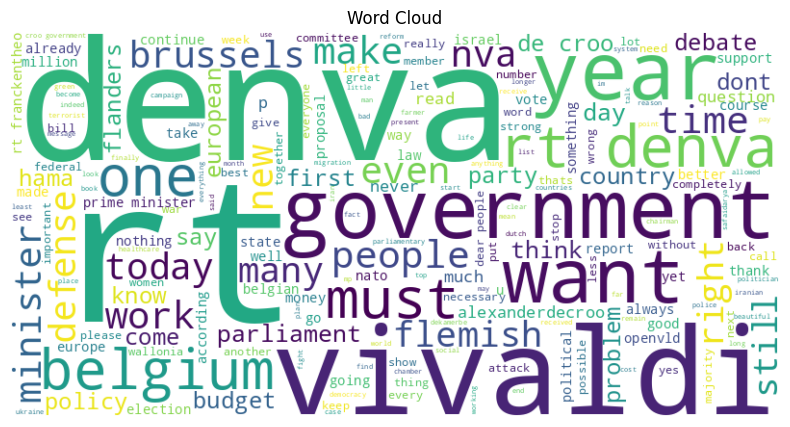

In [ ]:
# NVA

# Combine all the text data into a single string
text = ' '.join([' '.join(words) for words in nva_tweets['translated_text']])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

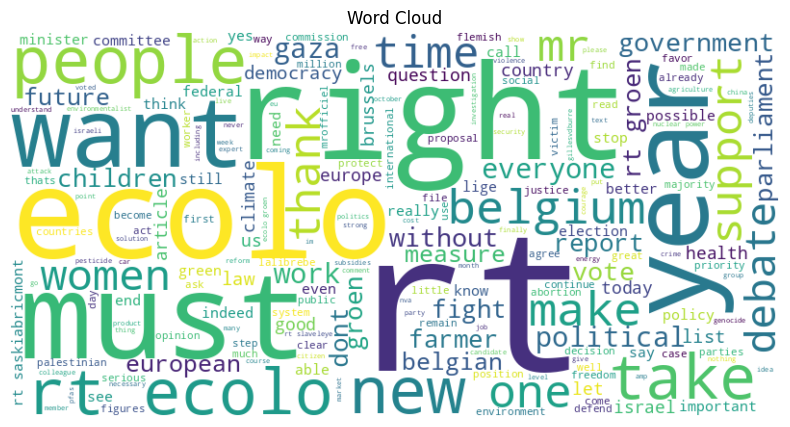

In [ ]:
# Groen

# Combine all the text data into a single string
text = ' '.join([' '.join(words) for words in groen_tweets['translated_text']])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

## Further exploring time

### Tweet activity

In [10]:
# NVA

nva_tweets['date'] = pd.to_datetime(nva_tweets['timeset']).dt.date
tweet_counts = nva_tweets.groupby('date').size()

# Print the tweet counts
df_nva_dates = pd.DataFrame(tweet_counts)
df_nva_dates.to_csv('df_nva_dates.csv', index=False)

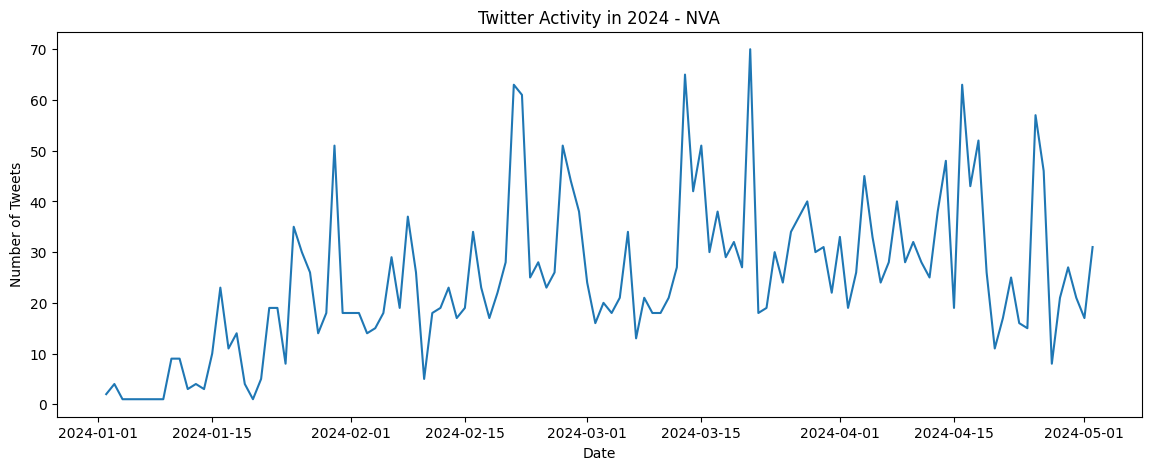

In [ ]:
import matplotlib.pyplot as plt

nva_tweets['date'] = pd.to_datetime(nva_tweets['date'])

df_2024 = nva_tweets[nva_tweets['date'].dt.year == 2024]

# Group by date and count the number of tweets per day
tweet_counts = df_2024.groupby('date').size()

# Group by date and count the number of tweets per day
tweet_counts = df_2024.groupby('date').size()

# Create a line plot of the tweet counts
plt.figure(figsize=(14,5)) # set the figure size to 10 inches by 5 inches
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity in 2024 - NVA')
plt.show()

In [7]:
# Groen

groen_tweets['date'] = pd.to_datetime(groen_tweets['timeset']).dt.date
tweet_counts = groen_tweets.groupby('date').size()

nva_tweets['date'] = pd.to_datetime(nva_tweets['timeset']).dt.date
tweet_counts = nva_tweets.groupby('date').size()

# Print the tweet counts
df_groen_dates = pd.DataFrame(tweet_counts)
df_nva_dates.to_csv('df_nva_dates.csv', index=False)

date
2013-12-04     1
2013-12-19     1
2020-12-04     2
2021-03-22     1
2021-07-14     2
              ..
2024-04-28     1
2024-04-29    16
2024-04-30    10
2024-05-01     7
2024-05-02     5
Length: 186, dtype: int64


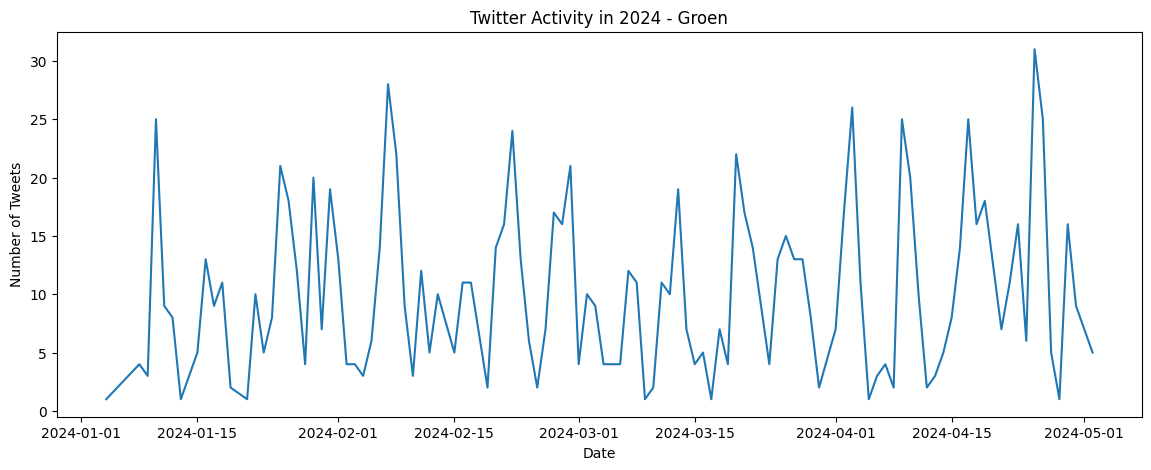

In [ ]:
import matplotlib.pyplot as plt

groen_tweets['date'] = pd.to_datetime(groen_tweets['date'])

df_2024 = groen_tweets[groen_tweets['date'].dt.year == 2024]

# Group by date and count the number of tweets per day
tweet_counts = df_2024.groupby('date').size()

# Group by date and count the number of tweets per day
tweet_counts = df_2024.groupby('date').size()

# Create a line plot of the tweet counts
plt.figure(figsize=(14,5)) # set the figure size to 10 inches by 5 inches
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity in 2024 - Groen')
plt.show()

### Tweet activity, 1 plot

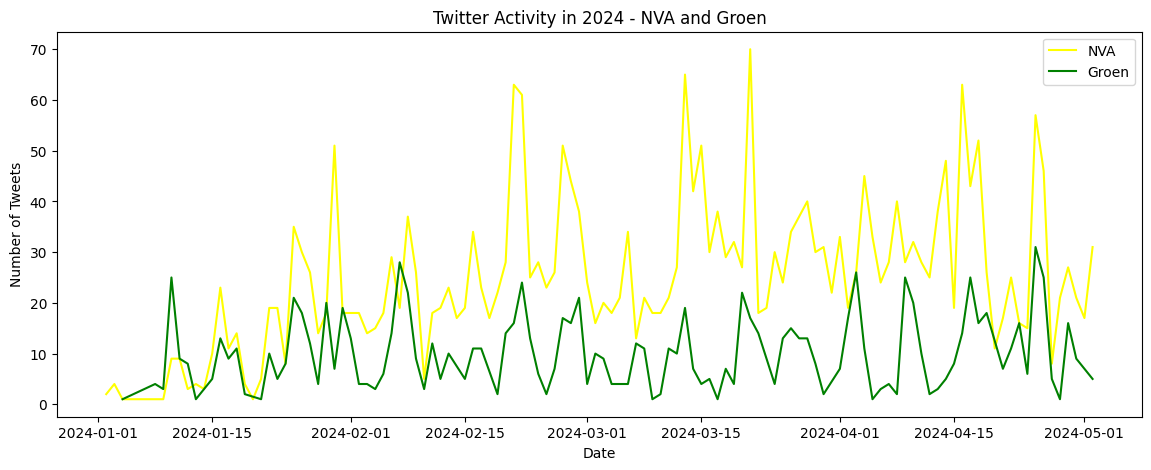

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' columns are in datetime format
nva_tweets['date'] = pd.to_datetime(nva_tweets['date'])
groen_tweets['date'] = pd.to_datetime(groen_tweets['date'])

# Filter tweets for the year 2024
nva_2024 = nva_tweets[nva_tweets['date'].dt.year == 2024]
groen_2024 = groen_tweets[groen_tweets['date'].dt.year == 2024]

# Group by date and count the number of tweets per day
nva_tweet_counts = nva_2024.groupby('date').size()
groen_tweet_counts = groen_2024.groupby('date').size()

# Create a line plot for both tweet counts on the same plot
plt.figure(figsize=(14, 5))  # set the figure size

plt.plot(nva_tweet_counts.index, nva_tweet_counts.values, color='yellow', label='NVA')
plt.plot(groen_tweet_counts.index, groen_tweet_counts.values, color='green', label='Groen')

plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity in 2024 - NVA and Groen')
plt.legend()  # add a legend to differentiate the lines
plt.show()

### Tweet activity per cluster NVA

<ipython-input-100-eb425ba7a30a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



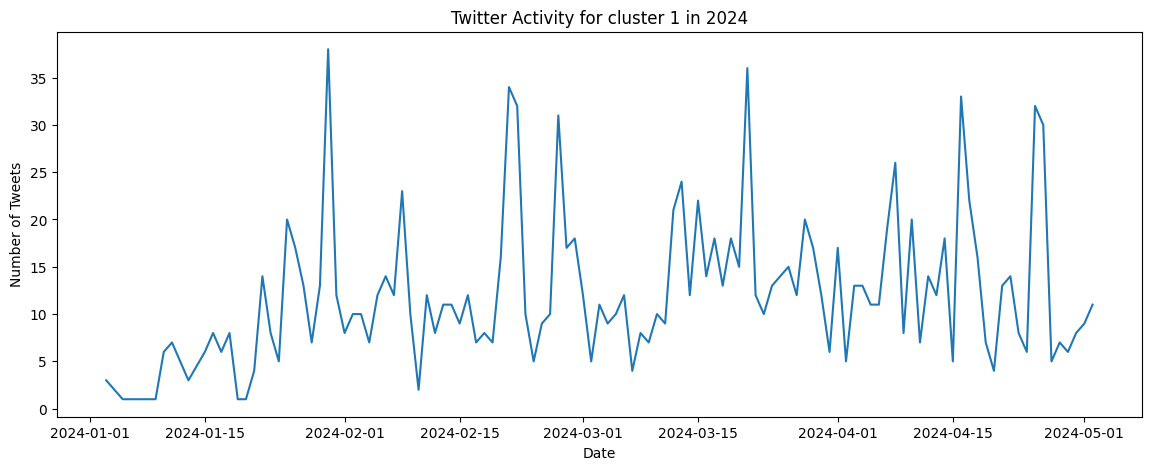

In [ ]:
cluster1 = nva_tweets[nva_tweets['cluster'] == 1]

cluster1['date'] = pd.to_datetime(cluster1['date'])

df_cluster1_2024 = cluster1[cluster1['date'].dt.year == 2024]

# Group by date and count the number of tweets per day
tweet_counts = df_cluster1_2024.groupby('date').size()

# Group by date and count the number of tweets per day
tweet_counts = df_cluster1_2024.groupby('date').size()

# Create a line plot of the tweet counts
plt.figure(figsize=(14,5)) # set the figure size to 10 inches by 5 inches
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for cluster 1 in 2024')
plt.show()

<ipython-input-102-d99fe31cfe55>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



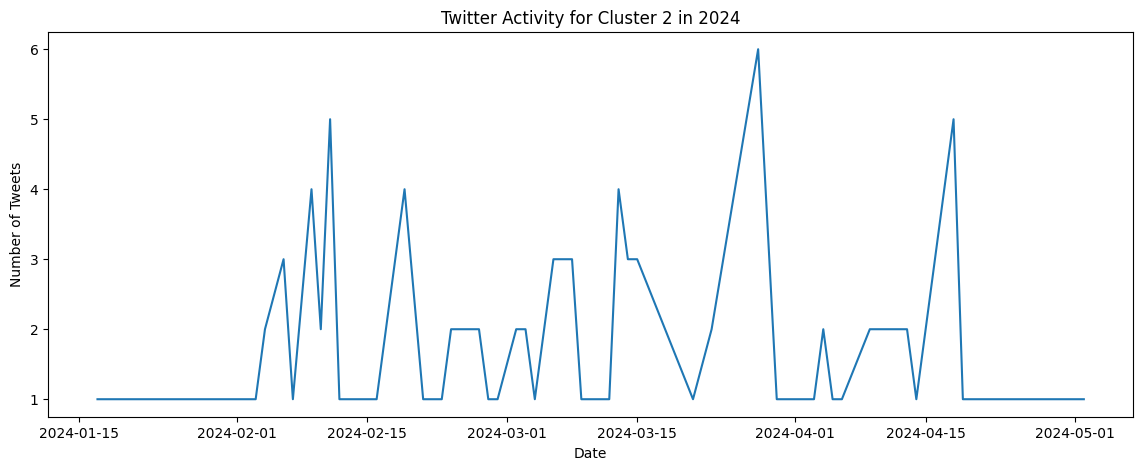

In [ ]:
# Cluster 2
cluster2 = nva_tweets[nva_tweets['cluster'] == 2]
cluster2['date'] = pd.to_datetime(cluster2['date'])
df_cluster2_2024 = cluster2[cluster2['date'].dt.year == 2024]
tweet_counts = df_cluster2_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 2 in 2024')
plt.show()

<ipython-input-103-880d6bbbc810>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



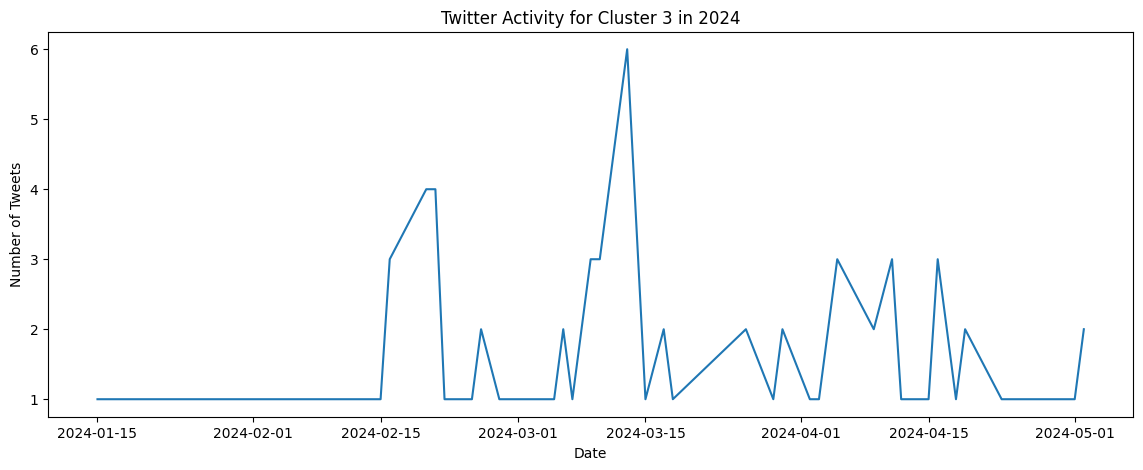

In [ ]:
# Cluster 3
cluster3 = nva_tweets[nva_tweets['cluster'] == 3]
cluster3['date'] = pd.to_datetime(cluster3['date'])
df_cluster3_2024 = cluster3[cluster3['date'].dt.year == 2024]
tweet_counts = df_cluster3_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 3 in 2024')
plt.show()

<ipython-input-104-17f632ca0508>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



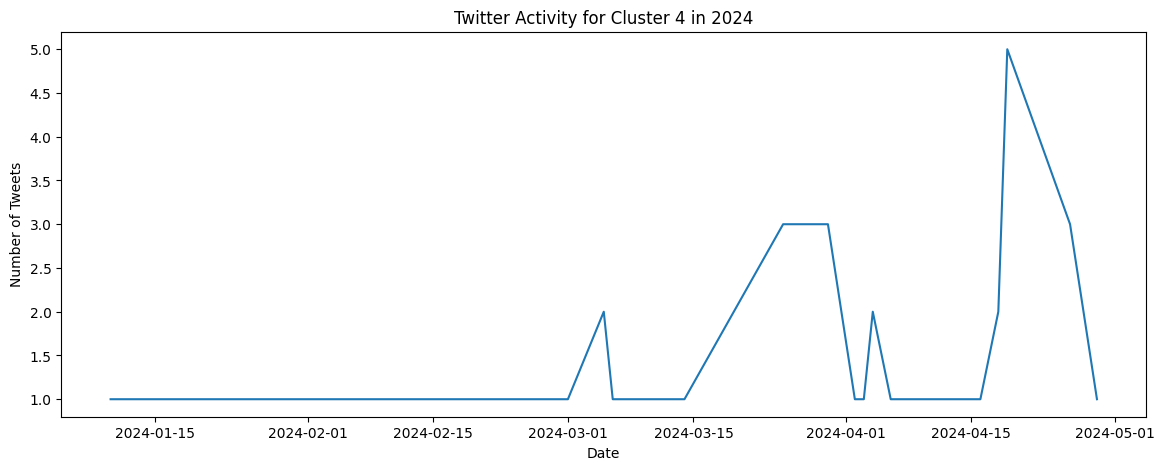

In [ ]:
# Cluster 4
cluster4 = nva_tweets[nva_tweets['cluster'] == 4]
cluster4['date'] = pd.to_datetime(cluster4['date'])
df_cluster4_2024 = cluster4[cluster4['date'].dt.year == 2024]
tweet_counts = df_cluster4_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 4 in 2024')
plt.show()

<ipython-input-106-67375a506606>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



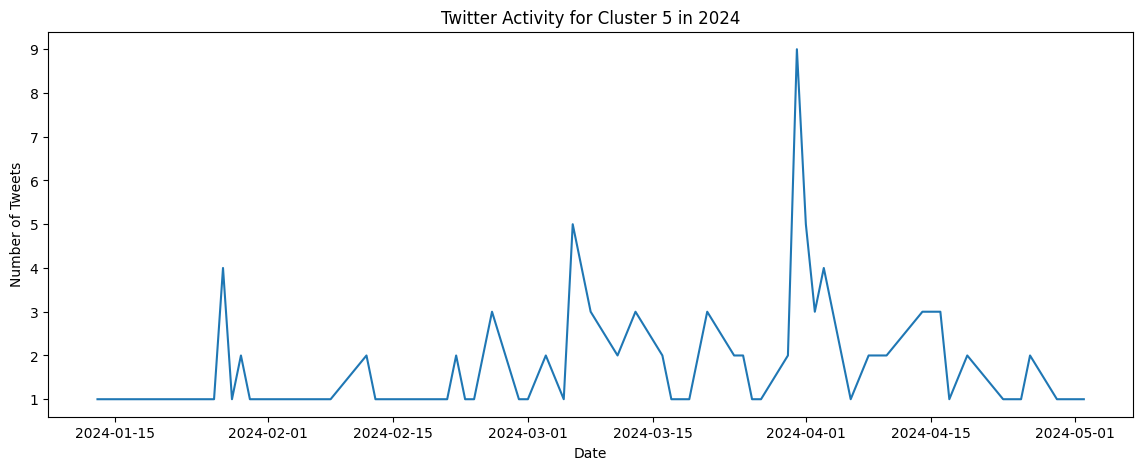

In [ ]:
# Cluster 5
cluster5 = nva_tweets[nva_tweets['cluster'] == 5]
cluster5['date'] = pd.to_datetime(cluster5['date'])
df_cluster5_2024 = cluster5[cluster5['date'].dt.year == 2024]
tweet_counts = df_cluster5_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 5 in 2024')
plt.show()

<ipython-input-108-931589046049>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



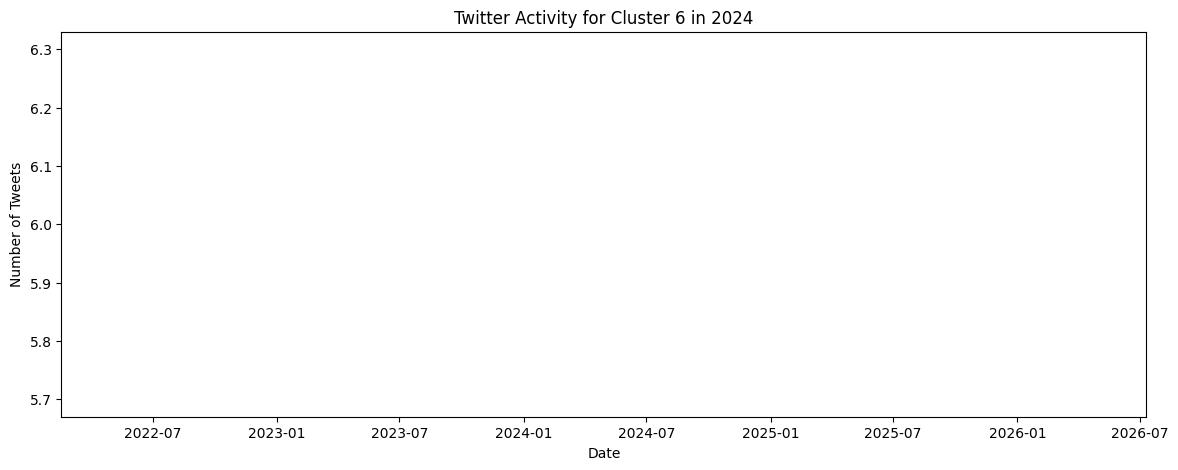

In [ ]:
# Cluster 6
cluster6 = nva_tweets[nva_tweets['cluster'] == 6]
cluster6['date'] = pd.to_datetime(cluster6['date'])
df_cluster6_2024 = cluster6[cluster6['date'].dt.year == 2024]
tweet_counts = df_cluster6_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 6 in 2024')
plt.show()

<ipython-input-109-4ef336533b1d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



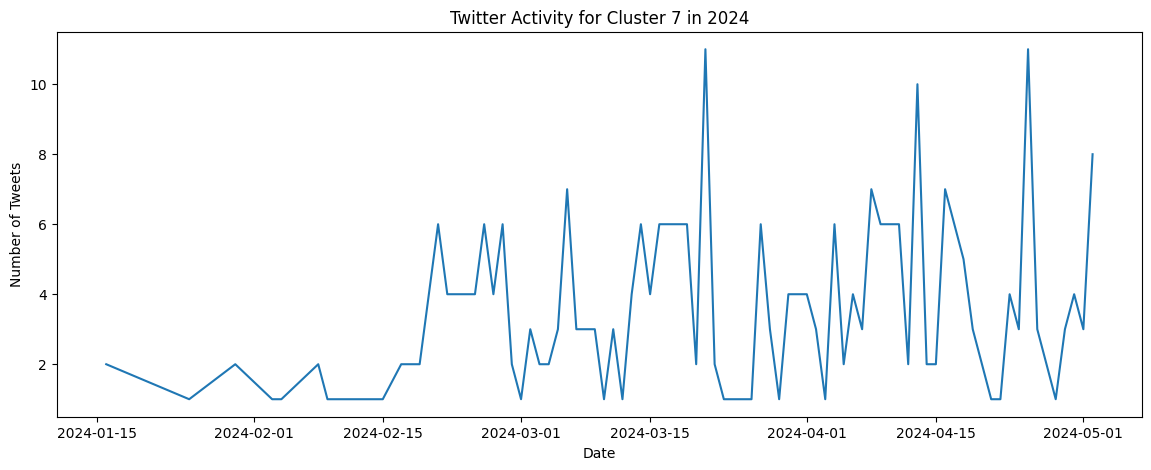

In [ ]:
# Cluster 7
cluster7 = nva_tweets[nva_tweets['cluster'] == 7]
cluster7['date'] = pd.to_datetime(cluster7['date'])
df_cluster7_2024 = cluster7[cluster7['date'].dt.year == 2024]
tweet_counts = df_cluster7_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 7 in 2024')
plt.show()

<ipython-input-110-b3fa748a4e50>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



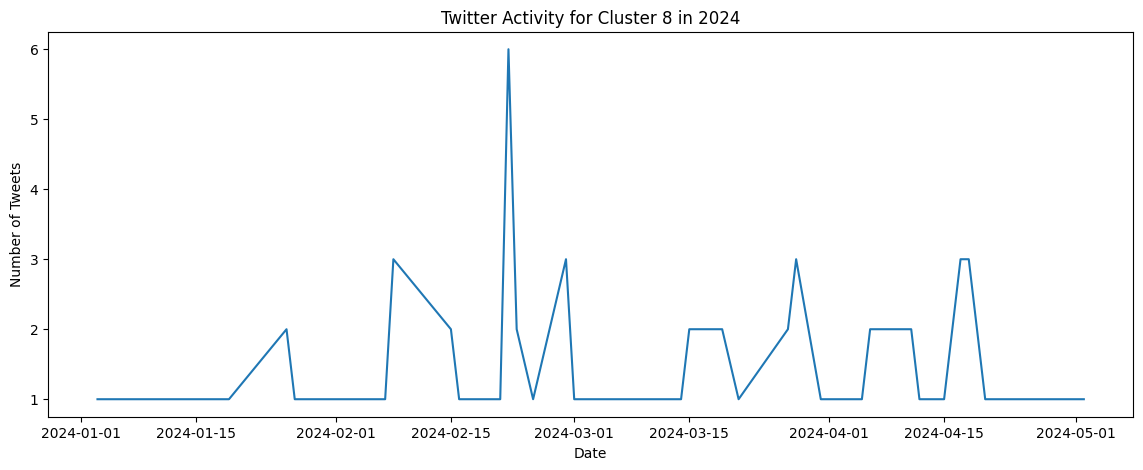

In [ ]:
# Cluster 8
cluster8 = nva_tweets[nva_tweets['cluster'] == 8]
cluster8['date'] = pd.to_datetime(cluster8['date'])
df_cluster8_2024 = cluster8[cluster8['date'].dt.year == 2024]
tweet_counts = df_cluster8_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 8 in 2024')
plt.show()

<ipython-input-111-d14e82781596>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



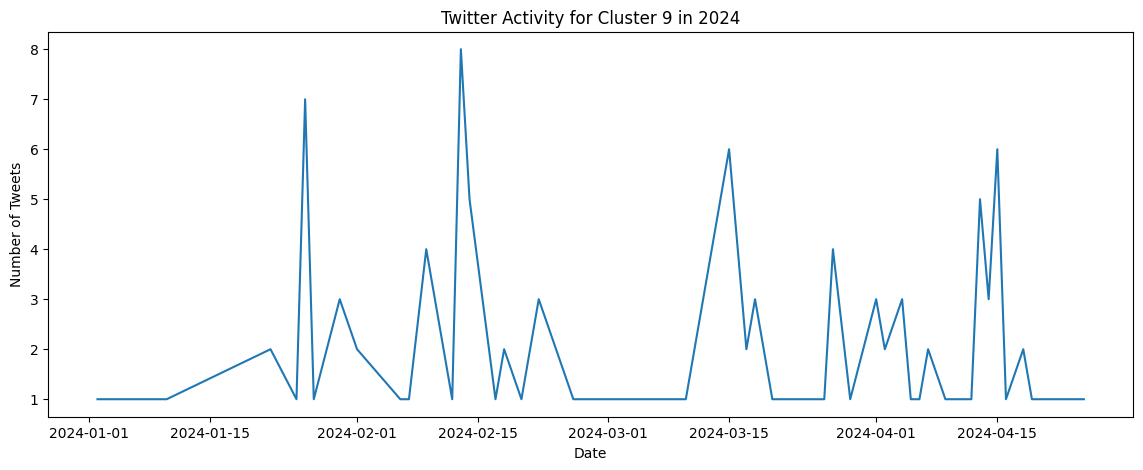

In [ ]:
# Cluster 9
cluster9 = nva_tweets[nva_tweets['cluster'] == 9]
cluster9['date'] = pd.to_datetime(cluster9['date'])
df_cluster9_2024 = cluster9[cluster9['date'].dt.year == 2024]
tweet_counts = df_cluster9_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 9 in 2024')
plt.show()

<ipython-input-112-dc3f4502648e>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



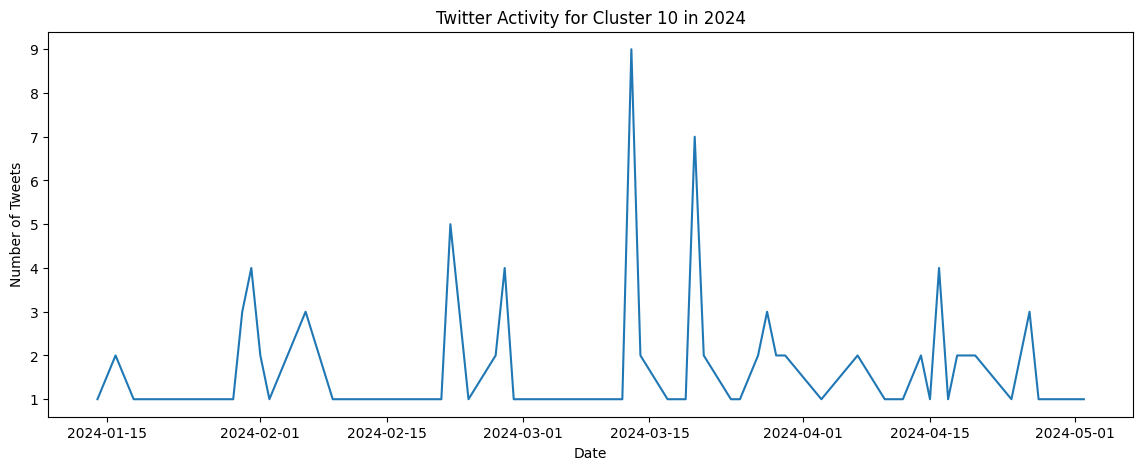

In [ ]:
# Cluster 10
cluster10 = nva_tweets[nva_tweets['cluster'] == 10]
cluster10['date'] = pd.to_datetime(cluster10['date'])
df_cluster10_2024 = cluster10[cluster10['date'].dt.year == 2024]
tweet_counts = df_cluster10_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 10 in 2024')
plt.show()

<ipython-input-113-7e98fa3e7c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



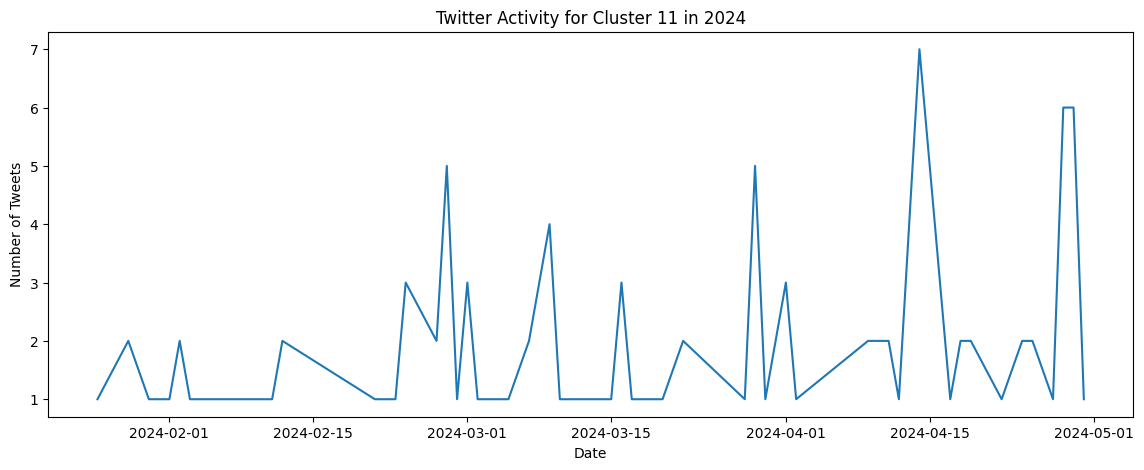

In [ ]:
# Cluster 11
cluster11 = nva_tweets[nva_tweets['cluster'] == 11]
cluster11['date'] = pd.to_datetime(cluster11['date'])
df_cluster11_2024 = cluster11[cluster11['date'].dt.year == 2024]
tweet_counts = df_cluster11_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 11 in 2024')
plt.show()

<ipython-input-114-9bbc412935a2>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



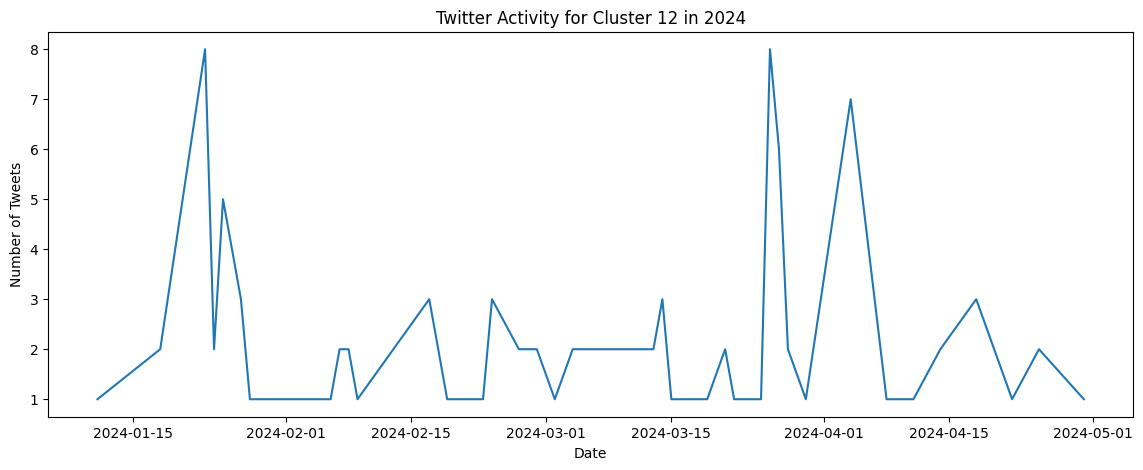

In [ ]:
# Cluster 12
cluster12 = nva_tweets[nva_tweets['cluster'] == 12]
cluster12['date'] = pd.to_datetime(cluster12['date'])
df_cluster12_2024 = cluster12[cluster12['date'].dt.year == 2024]
tweet_counts = df_cluster12_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 12 in 2024')
plt.show()

<ipython-input-115-4f9d01709b61>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



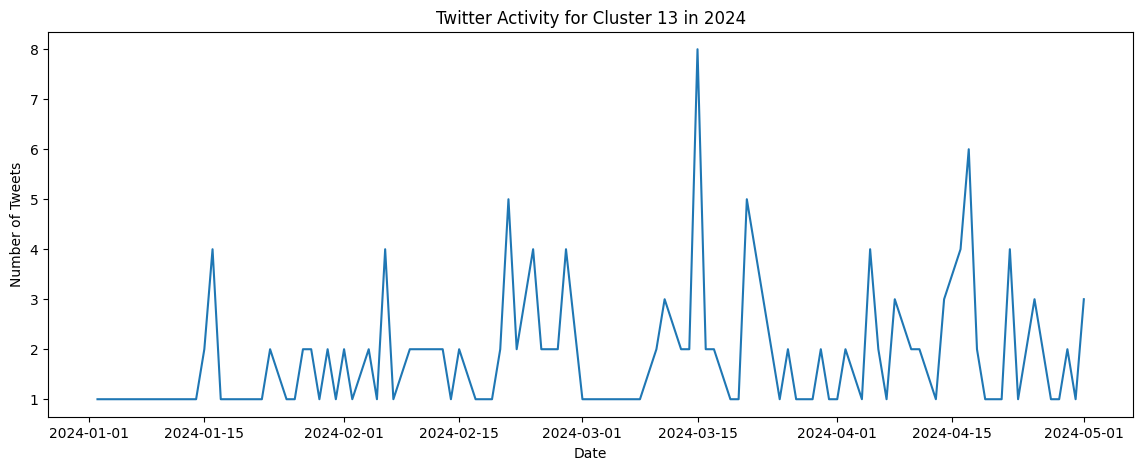

In [ ]:
# Cluster 13
cluster13 = nva_tweets[nva_tweets['cluster'] == 13]
cluster13['date'] = pd.to_datetime(cluster13['date'])
df_cluster13_2024 = cluster13[cluster13['date'].dt.year == 2024]
tweet_counts = df_cluster13_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 13 in 2024')
plt.show()

<ipython-input-116-28bd8383fadf>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



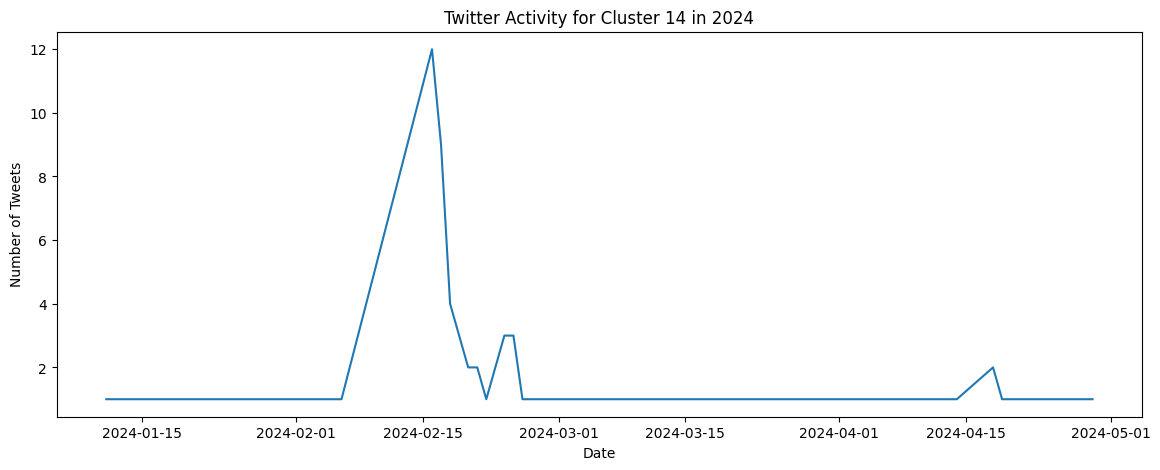

In [ ]:
# Cluster 14
cluster14 = nva_tweets[nva_tweets['cluster'] == 14]
cluster14['date'] = pd.to_datetime(cluster14['date'])
df_cluster14_2024 = cluster14[cluster14['date'].dt.year == 2024]
tweet_counts = df_cluster14_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 14 in 2024')
plt.show()

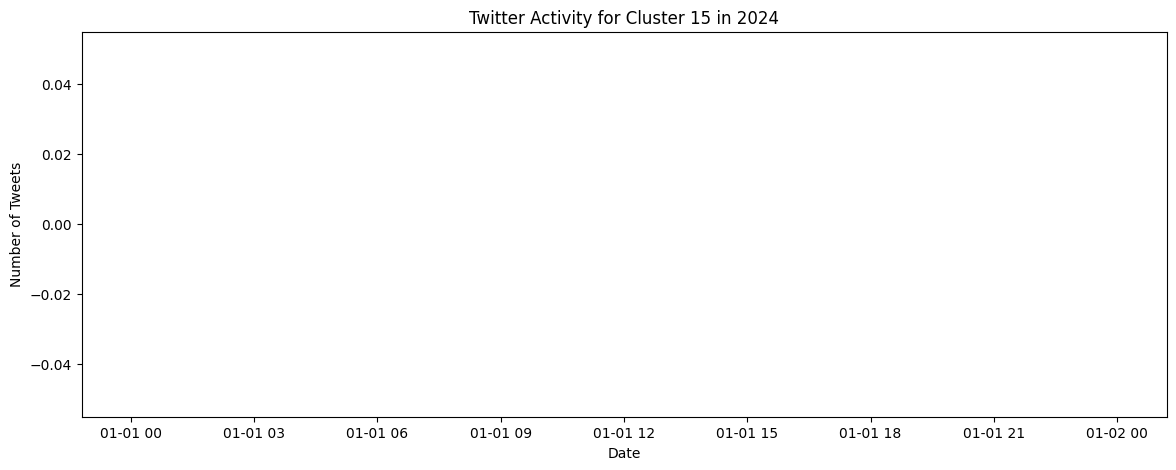

In [ ]:
# Cluster 15
cluster15 = nva_tweets[nva_tweets['cluster'] == 15]
cluster15['date'] = pd.to_datetime(cluster15['date'])
df_cluster15_2024 = cluster15[cluster15['date'].dt.year == 2024]
tweet_counts = df_cluster15_2024.groupby('date').size()
plt.figure(figsize=(14, 5))
plt.plot(tweet_counts.index, tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity for Cluster 15 in 2024')
plt.show()


<ipython-input-121-7dda091cbad5>:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



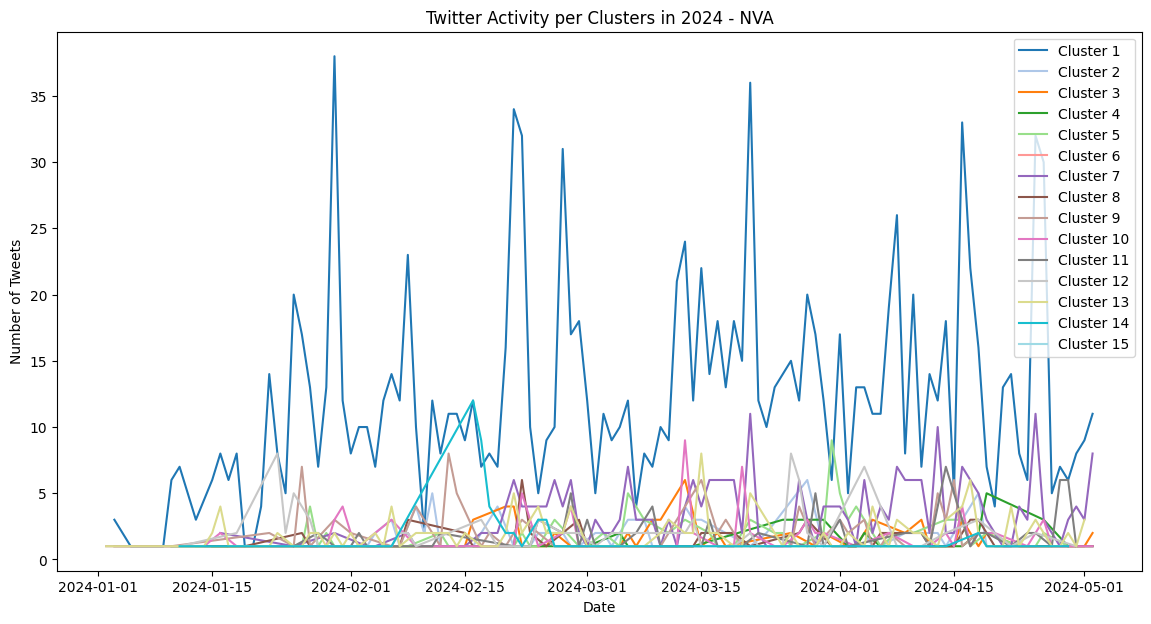

In [ ]:
# ALL CLUSTERS
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Ensure 'date' column is in datetime format
nva_tweets['date'] = pd.to_datetime(nva_tweets['date'])

# Define a colormap
colors = cm.get_cmap('tab20', 15)  # Use the 'tab20' colormap with 15 distinct colors

plt.figure(figsize=(14, 7))  # Set the figure size

# Loop through clusters 1 to 15
for cluster_id in range(1, 16):
    # Filter tweets for the current cluster
    cluster = nva_tweets[nva_tweets['cluster'] == cluster_id]

    # Filter tweets for the year 2024
    df_cluster_2024 = cluster[cluster['date'].dt.year == 2024]

    # Group by date and count the number of tweets per day
    tweet_counts = df_cluster_2024.groupby('date').size()

    # Plot the tweet counts
    plt.plot(tweet_counts.index, tweet_counts.values, label=f'Cluster {cluster_id}', color=colors(cluster_id - 1))

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity per Clusters in 2024 - NVA')
plt.legend(loc='upper right')
plt.show()

### Tweet activity per cluster Groen

<ipython-input-120-41739ef8e077>:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



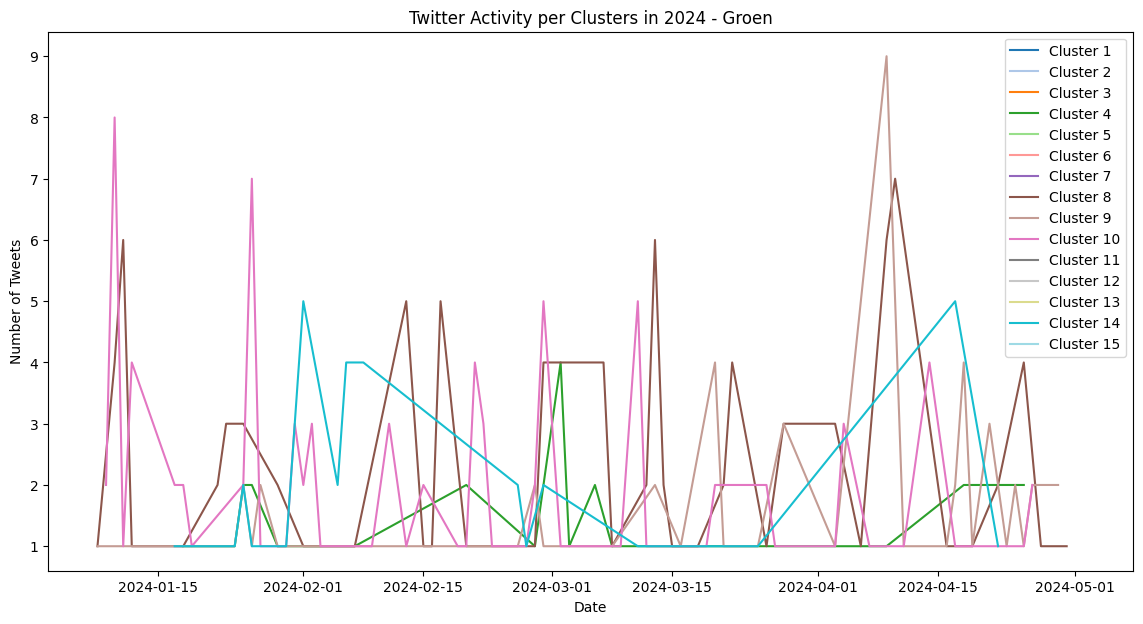

In [ ]:
# ALL CLUSTERS
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Ensure 'date' column is in datetime format
groen_tweets['date'] = pd.to_datetime(groen_tweets['date'])

# Define a colormap
colors = cm.get_cmap('tab20', 15)  # Use the 'tab20' colormap with 15 distinct colors

plt.figure(figsize=(14, 7))  # Set the figure size

# Loop through clusters 1 to 15
for cluster_id in range(1, 16):
    # Filter tweets for the current cluster
    cluster = groen_tweets[groen_tweets['cluster'] == cluster_id]

    # Filter tweets for the year 2024
    df_cluster_2024 = cluster[cluster['date'].dt.year == 2024]

    # Group by date and count the number of tweets per day
    tweet_counts = df_cluster_2024.groupby('date').size()

    # Plot the tweet counts
    plt.plot(tweet_counts.index, tweet_counts.values, label=f'Cluster {cluster_id}', color=colors(cluster_id - 1))

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Twitter Activity per Clusters in 2024 - Groen')
plt.legend(loc='upper right')
plt.show()

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



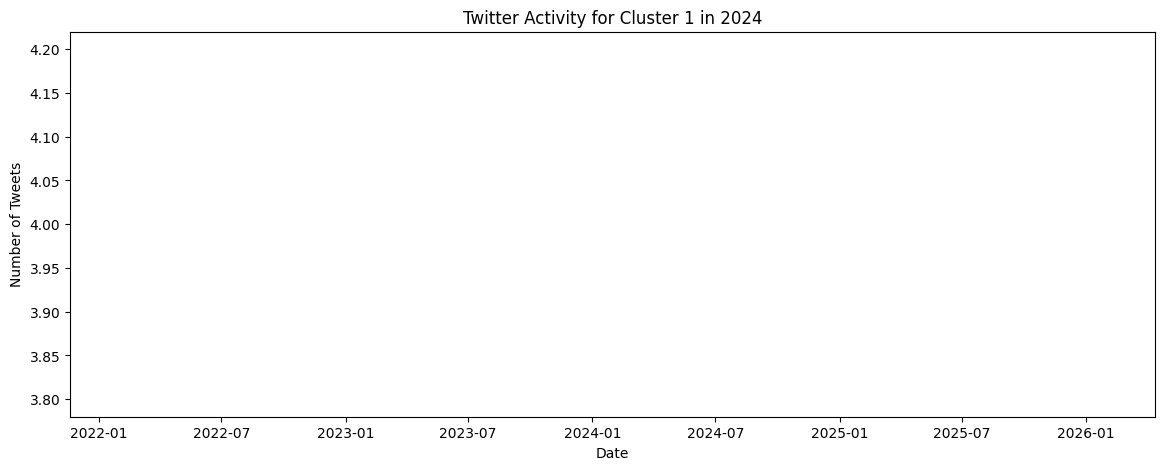

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



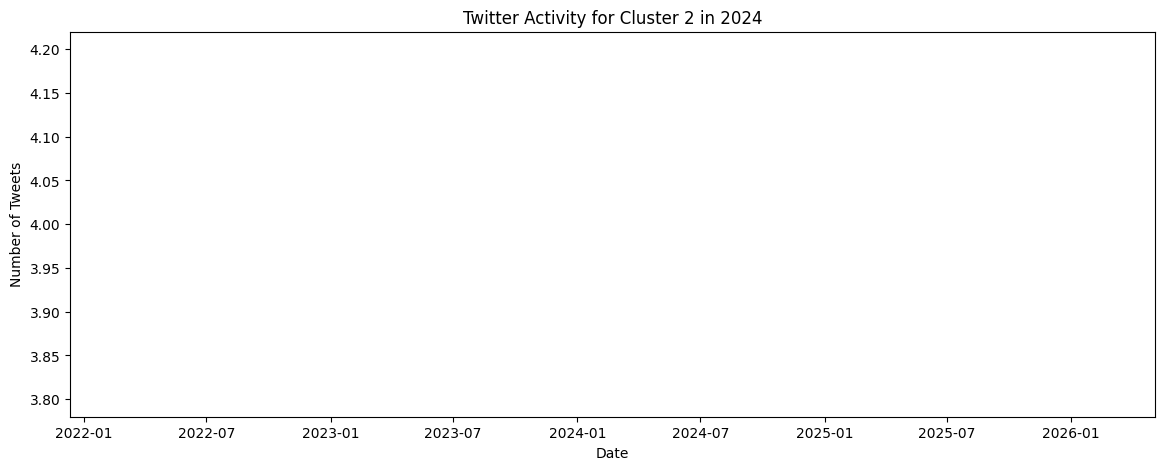

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



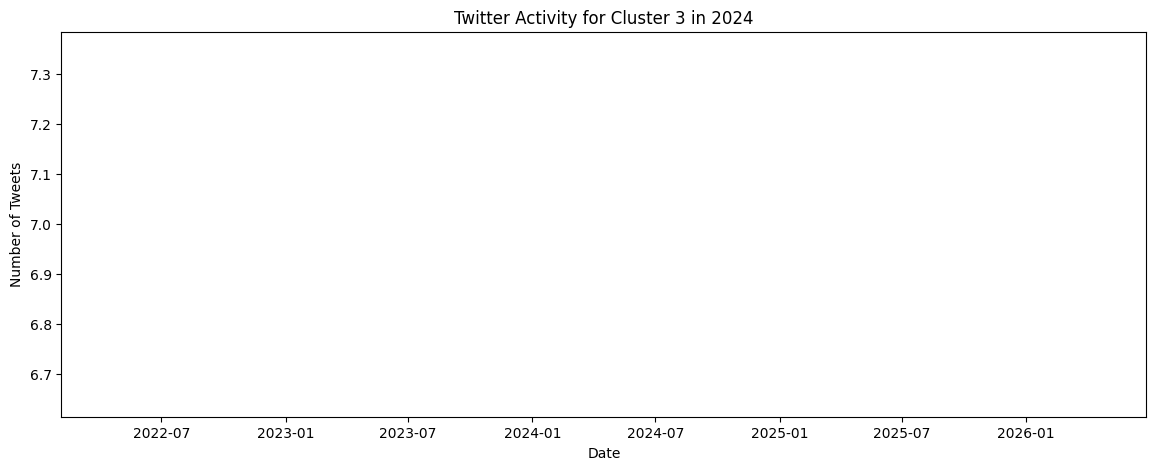

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



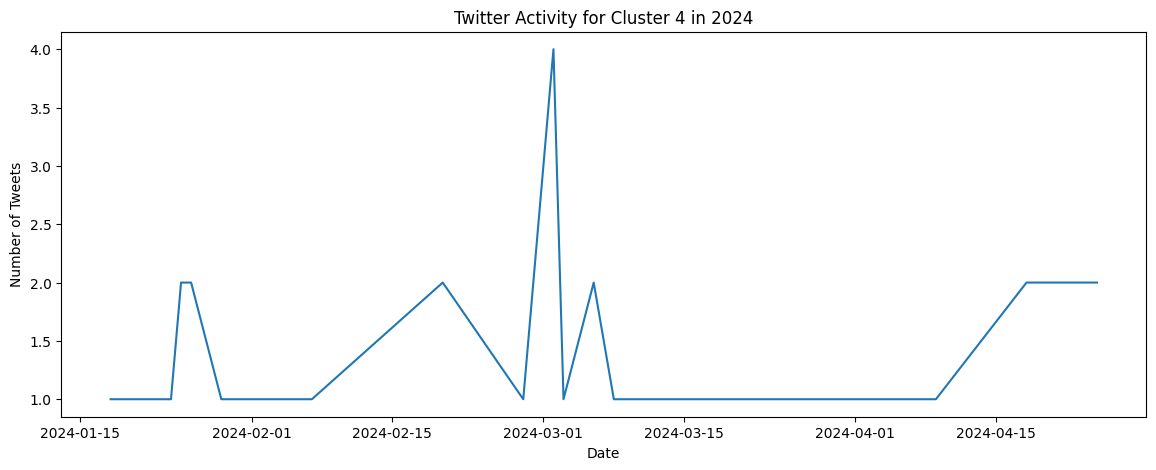

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



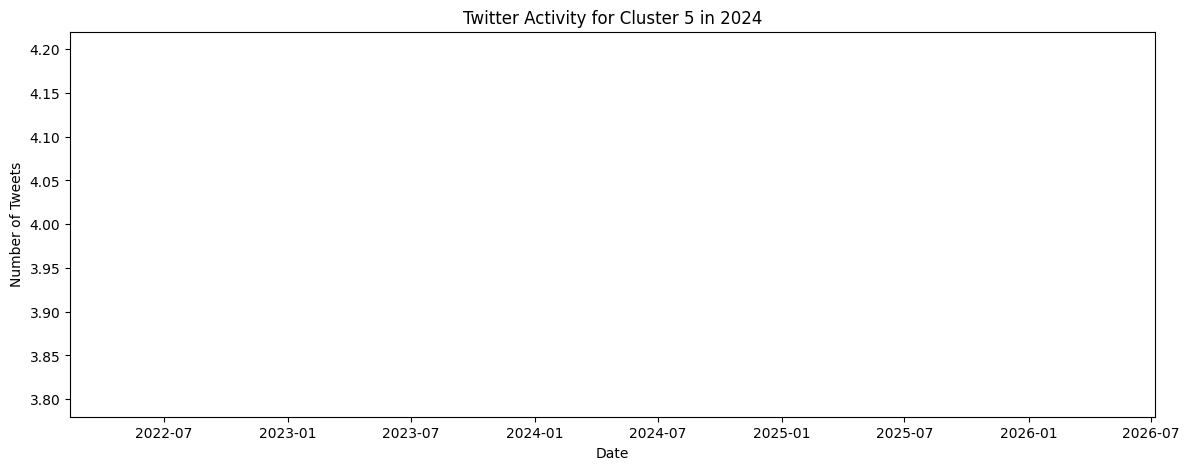

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



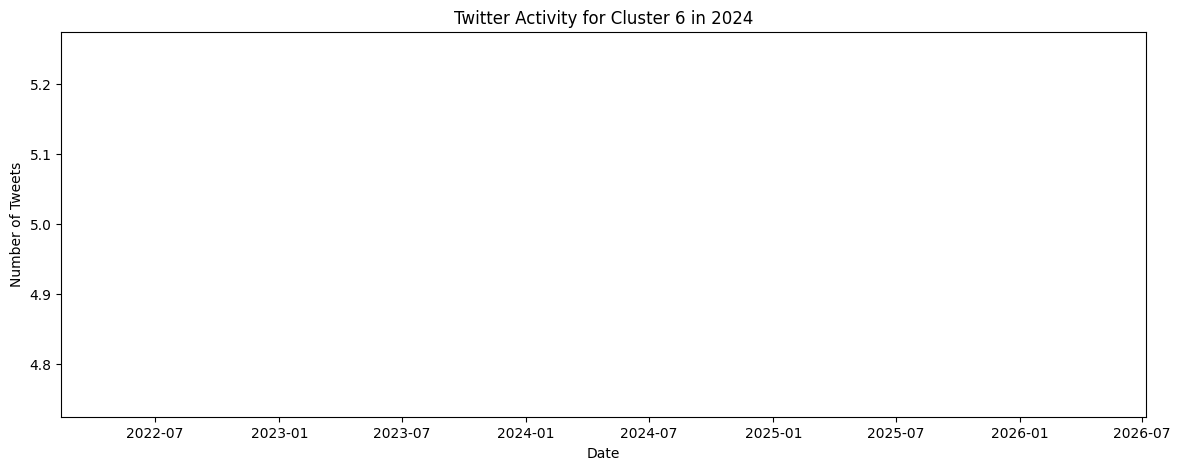

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



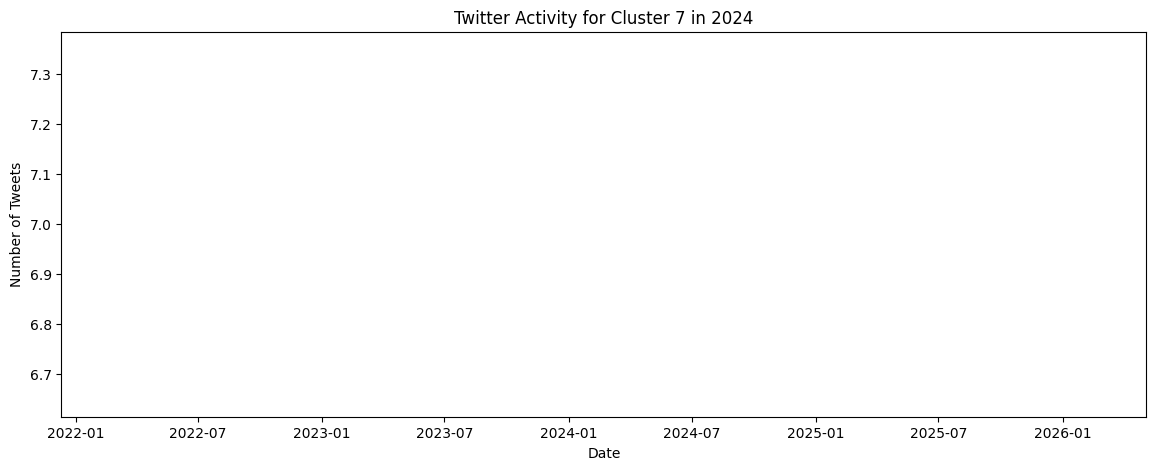

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



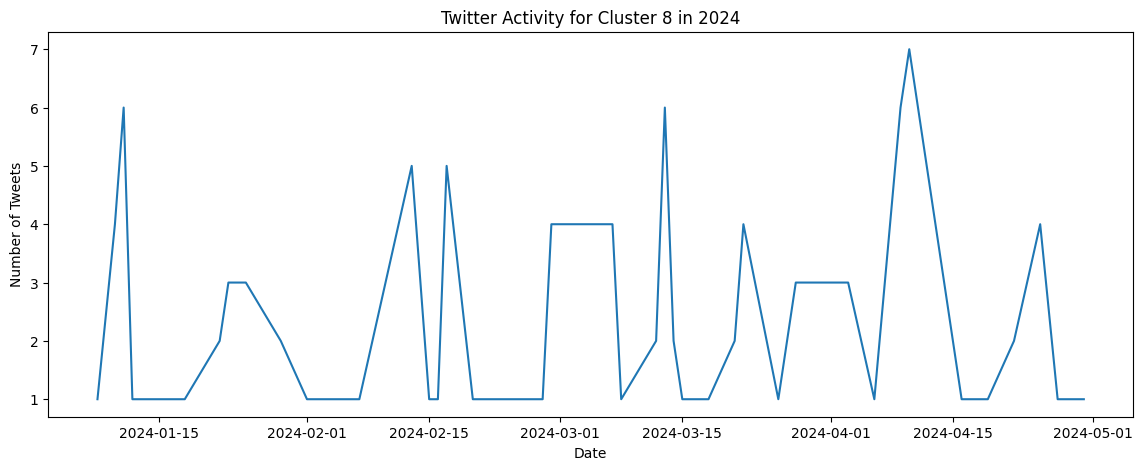

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



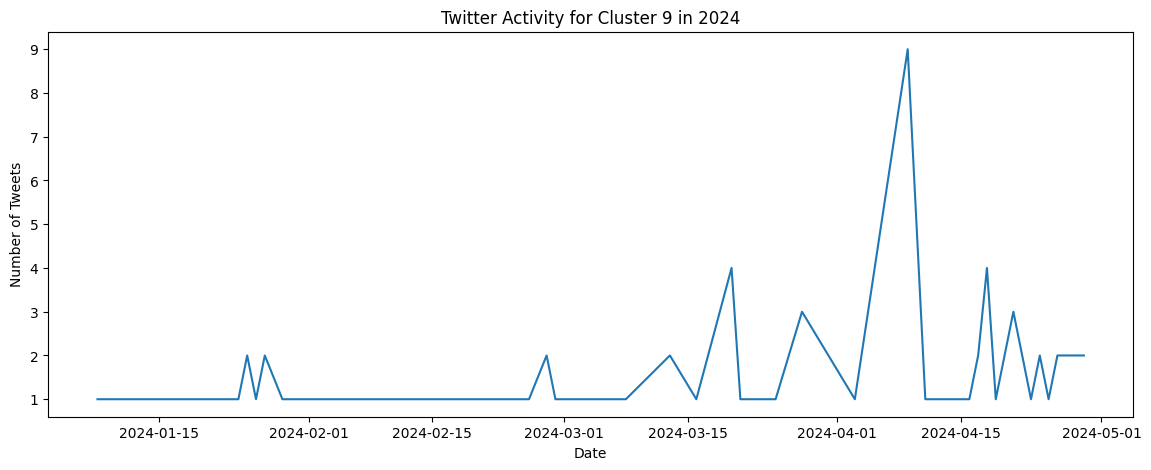

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



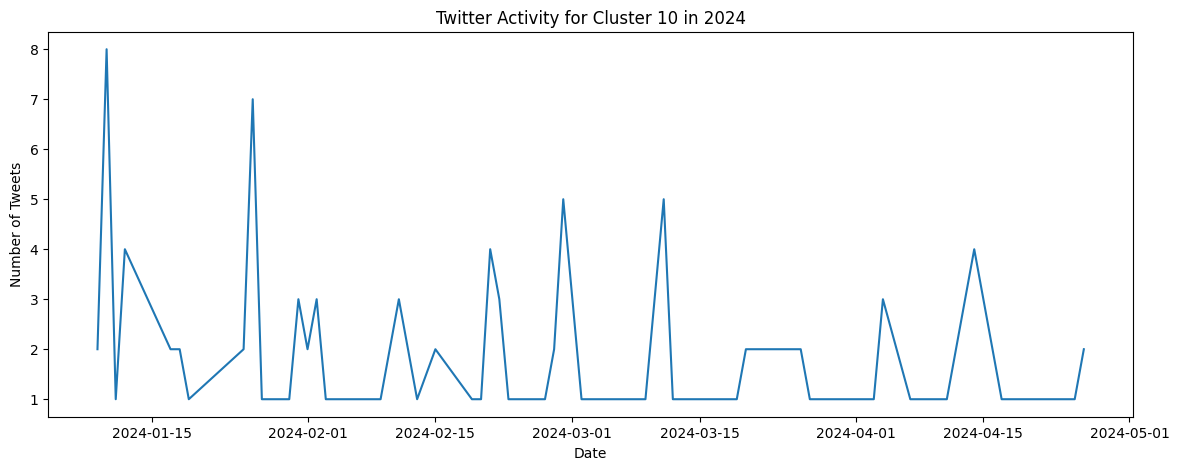

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



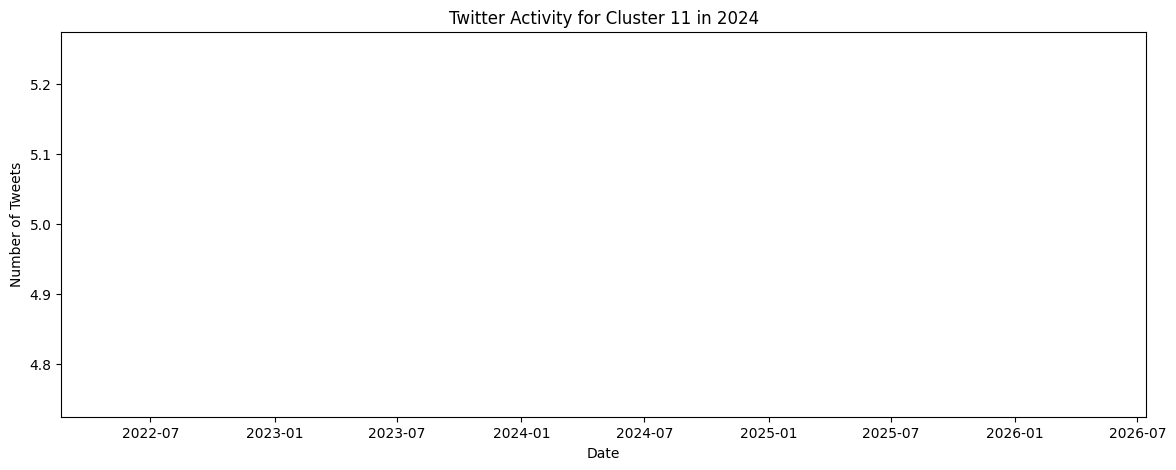

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



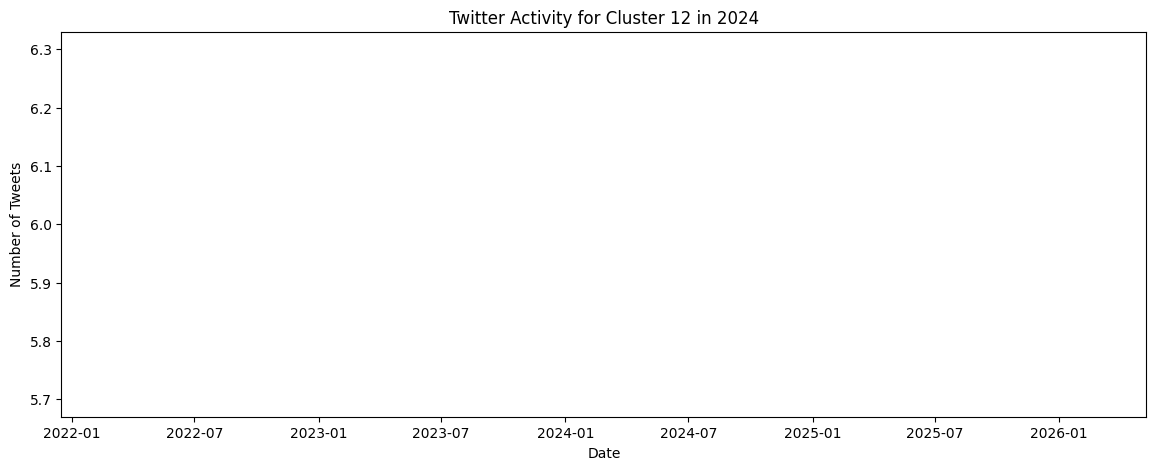

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



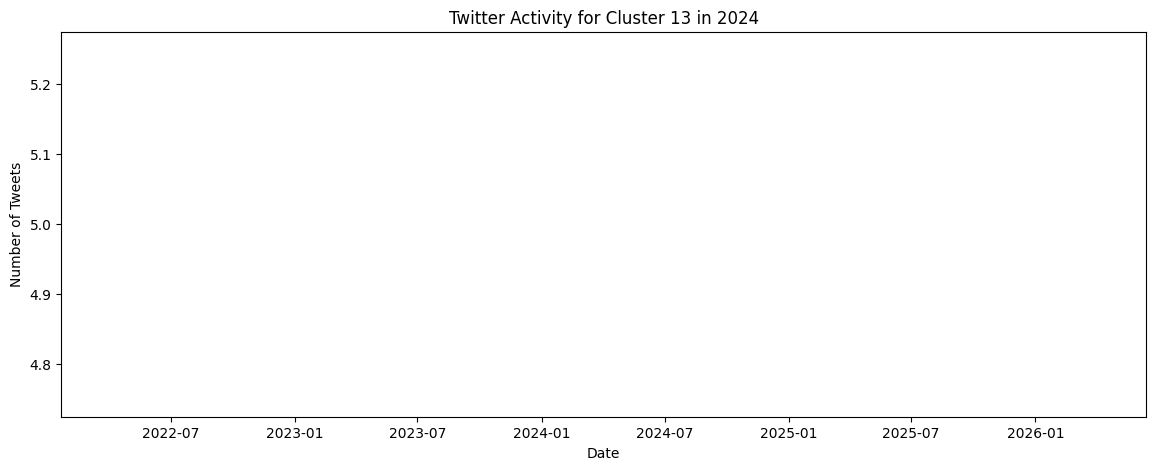

<ipython-input-123-5f534fd2b198>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



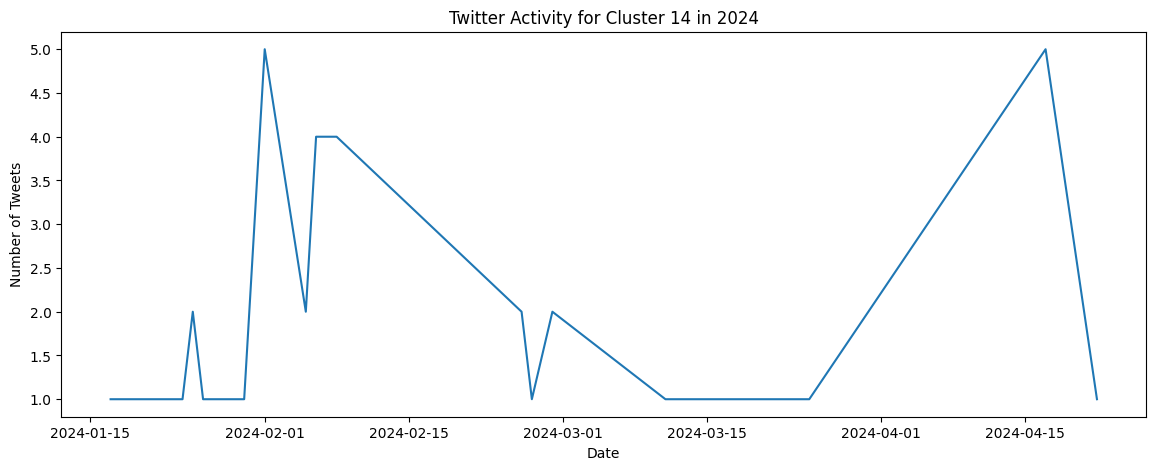

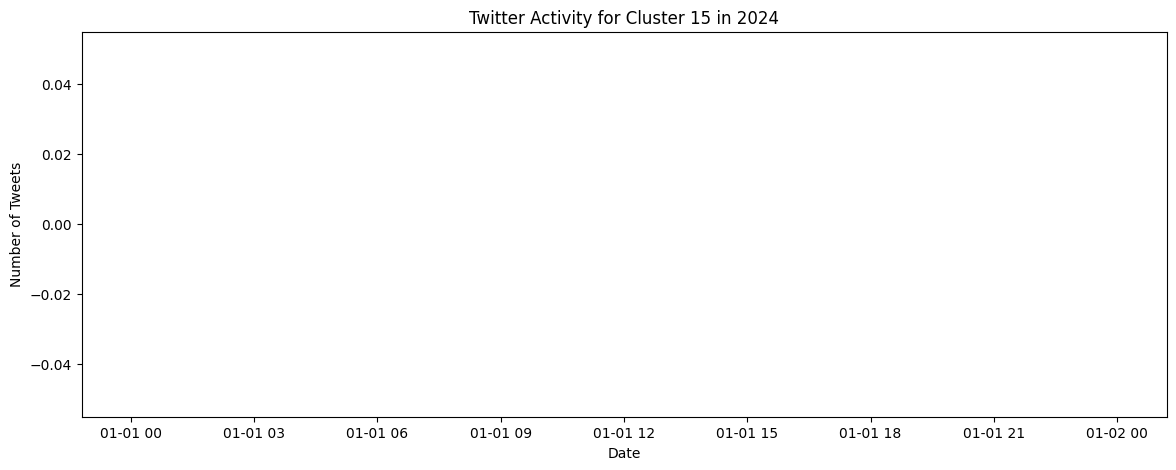

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming groen_tweets is already defined and loaded
for cluster_number in range(1, 16):
    cluster_data = groen_tweets[groen_tweets['cluster'] == cluster_number]
    cluster_data['date'] = pd.to_datetime(cluster_data['date'])
    df_cluster_2024 = cluster_data[cluster_data['date'].dt.year == 2024]
    tweet_counts = df_cluster_2024.groupby('date').size()

    plt.figure(figsize=(14, 5))
    plt.plot(tweet_counts.index, tweet_counts.values)
    plt.xlabel('Date')
    plt.ylabel('Number of Tweets')
    plt.title(f'Twitter Activity for Cluster {cluster_number} in 2024')
    plt.show()